# VGG

## Setup Kaggle di Colab

In [1]:
# Install library Kaggle untuk download dataset
!pip install kaggle -q
import os
import sys

# Buat direktori .kaggle jika belum ada
!mkdir -p ~/.kaggle

# Cek apakah file kaggle.json sudah diupload
if os.path.exists('/content/kaggle.json'):
    # Pindahkan kaggle.json ke direktori .kaggle
    !mv /content/kaggle.json ~/.kaggle/
    # Set permission file agar secure
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json berhasil dikonfigurasi.")
else:
    print("kaggle.json tidak ditemukan di /content/. Silakan upload file kaggle.json terlebih dahulu.")

kaggle.json berhasil dikonfigurasi.


## Download Dataset dari Kaggle

In [2]:
# Download dataset CelebA 64x64 dari Kaggle
!kaggle datasets download -d therealcyberlord/50k-celeba-dataset-64x64

Dataset URL: https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64
License(s): unknown
  0% 0.00/78.1M [00:00<?, ?B/s]
100% 78.1M/78.1M [00:00<00:00, 1.54GB/s]


## Extract Dataset

In [3]:
import zipfile
import os

# Path file zip yang telah didownload
zip_file_path = '/content/50k-celeba-dataset-64x64.zip'

# Direktori tujuan ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'

# Buat folder ekstraksi jika belum ada
os.makedirs(extracted_path, exist_ok=True)

# Ekstrak file zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Dataset berhasil diekstrak.")
except FileNotFoundError:
    print(f"Error: File {zip_file_path} tidak ditemukan. Pastikan download berhasil.")
except zipfile.BadZipFile:
    print(f"Error: File {zip_file_path} bukan zip yang valid. Download mungkin corrupt.")
except Exception as e:
    print(f"Error saat ekstraksi: {e}")

Dataset berhasil diekstrak.


## Cek Isi Folder

In [4]:
import os

# Tampilkan isi direktori hasil ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'
print("Isi folder ekstraksi:")
print(os.listdir(extracted_path))

Isi folder ekstraksi:
['50k']


## Download Attribute File (Label)

In [5]:
# Download file atribut dari GitHub (alternatif jika gagal)
# Opsional: Bisa juga download manual dari Google Drive
# Link Google Drive: https://drive.google.com/drive/folders/1AA21MR8GeQdnOVgmNcbxCrbAjL1udj0l

import requests
import os

# URL file atribut CelebA
attribute_file_url = "https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt"
attribute_file_path = "/content/list_attr_celeba.txt"

print(f"Mencoba download file atribut dari: {attribute_file_url}")

try:
    response = requests.get(attribute_file_url, stream=True)
    response.raise_for_status()  # Raise error jika status 4xx atau 5xx

    with open(attribute_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"File atribut berhasil didownload ke: {attribute_file_path}")

except requests.exceptions.RequestException as e:
    print(f"Error saat download file atribut: {e}")
    print("Tidak dapat mendownload file dari URL yang diberikan.")
    print("Silakan download manual dari Google Drive dan upload ke Colab.")
except Exception as e:
    print(f"Error saat memproses file atribut: {e}")

Mencoba download file atribut dari: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Error saat download file atribut: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Tidak dapat mendownload file dari URL yang diberikan.
Silakan download manual dari Google Drive dan upload ke Colab.


## Load Attribute File

In [13]:
import pandas as pd
import numpy as np
import os

# Path file atribut yang sudah diupload
attribute_file_path = '/content/list_attr_celeba.txt'

if os.path.exists(attribute_file_path):
    print(f"File atribut ditemukan di: {attribute_file_path}")

    # Load file atribut CelebA
    # Format: baris pertama = jumlah data, baris kedua = nama kolom
    # Skip 1 baris pertama, gunakan regex untuk separator (bisa multiple spaces)
    attributes_df = pd.read_csv(attribute_file_path, sep=r'\s+', skiprows=1)

    # Tampilkan 5 baris pertama untuk verifikasi
    print("\nPreview Data Atribut:")
    display(attributes_df.head())

    # Pastikan variabel 'image_files' sudah ada dari step sebelumnya (load gambar)
    if 'image_files' in globals():
        # Ambil nama file gambar yang sudah diload (tanpa path)
        loaded_image_filenames = [os.path.basename(f) for f in image_files]

        # Pastikan index dataframe bertipe string untuk matching dengan filename
        attributes_df.index = attributes_df.index.astype(str)

        # Ambil kolom 'Male' sebagai label
        # Nilai: -1 = Female, 1 = Male
        if 'Male' in attributes_df.columns:
            # Reindex untuk mencocokkan urutan gambar yang diload
            loaded_attributes = attributes_df.reindex(loaded_image_filenames)

            # Ekstrak kolom 'Male' dan konversi -1 menjadi 0 (Female=0, Male=1)
            # Handle NaN values dengan fillna(-1) jika ada gambar tanpa label
            male_labels = loaded_attributes['Male'].fillna(-1).replace(-1, 0).values

            # Cek apakah jumlah label cocok dengan jumlah gambar
            if len(male_labels) != len(images):
                print(f"\nPeringatan: Jumlah label ({len(male_labels)}) tidak cocok dengan jumlah gambar ({len(images)}).")
                print("Mungkin ada gambar yang tidak memiliki label.")

            print(f"\nBerhasil load {len(male_labels)} label 'Male'.")
            print(f"Shape array label: {male_labels.shape}")
            print(f"Contoh 10 label pertama: {male_labels[:10]}")

        else:
            print("Kolom 'Male' tidak ditemukan dalam file atribut.")
            male_labels = None

    else:
        print("Error: Variabel 'image_files' tidak ditemukan. Jalankan cell load gambar terlebih dahulu.")
        attributes_df = None
        male_labels = None

else:
    print(f"File atribut ({attribute_file_path}) tidak ditemukan.")
    print("Silakan upload file 'list_attr_celeba.txt' ke direktori /content/")
    male_labels = None

# Validasi akhir: set male_labels ke None jika ada masalah
if male_labels is None or len(male_labels) != len(images):
    print("\nGagal load label atau jumlah tidak cocok. Setting male_labels = None.")
    male_labels = None

File atribut ditemukan di: /content/list_attr_celeba.txt

Preview Data Atribut:


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1



Berhasil load 10000 label 'Male'.
Shape array label: (10000,)
Contoh 10 label pertama: [0 0 0 1 0 0 0 0 1 0]


## Load Gambar ke Numpy

In [12]:
import os
import cv2
import numpy as np

# Direktori tempat gambar hasil ekstraksi
image_dir = '/content/celeba_dataset_kaggle/50k'

# Ukuran target gambar (dataset sudah 64x64)
image_size = (64, 64)

# List semua file gambar (format .jpg atau .png)
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Batasi jumlah gambar untuk eksperimen awal (opsional)
# Bisa dihapus atau diubah untuk load seluruh dataset
num_images_to_load = 10000  # Load 10,000 gambar
image_files = image_files[:num_images_to_load]

print(f"Memulai loading {len(image_files)} gambar...")

# Load dan preprocess gambar
images = []
for idx, file_name in enumerate(image_files):
    img_path = os.path.join(image_dir, file_name)
    img = cv2.imread(img_path)

    if img is not None:
        # Konversi dari BGR (OpenCV default) ke RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize jika ukuran tidak sesuai (meskipun dataset sudah 64x64)
        if img.shape[:2] != image_size:
            img = cv2.resize(img, image_size)

        images.append(img)
    else:
        print(f"Warning: Tidak dapat membaca gambar {img_path}")

    # Progress indicator setiap 1000 gambar
    if (idx + 1) % 1000 == 0:
        print(f"Progress: {idx + 1}/{len(image_files)} gambar diload")

# Konversi list ke NumPy array
images = np.array(images)

print(f"\nBerhasil load {len(images)} gambar.")
print(f"Shape array gambar: {images.shape}")
print(f"Tipe data: {images.dtype}")
print(f"Range nilai piksel: [{images.min()}, {images.max()}]")

Memulai loading 10000 gambar...
Progress: 1000/10000 gambar diload
Progress: 2000/10000 gambar diload
Progress: 3000/10000 gambar diload
Progress: 4000/10000 gambar diload
Progress: 5000/10000 gambar diload
Progress: 6000/10000 gambar diload
Progress: 7000/10000 gambar diload
Progress: 8000/10000 gambar diload
Progress: 9000/10000 gambar diload
Progress: 10000/10000 gambar diload

Berhasil load 10000 gambar.
Shape array gambar: (10000, 64, 64, 3)
Tipe data: uint8
Range nilai piksel: [0, 255]


## Split Data menjadi Training dan Validation

In [15]:
from sklearn.model_selection import train_test_split

# Cek apakah jumlah gambar dan label sama
if len(images) == len(male_labels):
    print(f"Jumlah gambar ({len(images)}) dan label ({len(male_labels)}) cocok. Melanjutkan split data.")

    # Split data: 80% training, 20% validation
    # stratify digunakan untuk menjaga distribusi kelas (Male/Female) tetap seimbang
    train_images, val_images, train_labels, val_labels = train_test_split(
        images,
        male_labels,
        test_size=0.2,      # 20% untuk validation
        random_state=42,    # Untuk reproducibility
        stratify=male_labels # Jaga keseimbangan kelas
    )

    print(f"\n=== Hasil Split Data ===")
    print(f"Training images shape: {train_images.shape}")
    print(f"Validation images shape: {val_images.shape}")
    print(f"Training labels shape: {train_labels.shape}")
    print(f"Validation labels shape: {val_labels.shape}")

    # Tampilkan distribusi kelas
    print(f"\n=== Distribusi Kelas ===")
    print(f"Training - Female: {(train_labels == 0).sum()}, Male: {(train_labels == 1).sum()}")
    print(f"Validation - Female: {(val_labels == 0).sum()}, Male: {(val_labels == 1).sum()}")

else:
    print(f"Error: Jumlah gambar ({len(images)}) dan label ({len(male_labels)}) tidak cocok!")
    print("Periksa kembali proses loading data.")
    train_images, val_images, train_labels, val_labels = None, None, None, None

Jumlah gambar (10000) dan label (10000) cocok. Melanjutkan split data.

=== Hasil Split Data ===
Training images shape: (8000, 64, 64, 3)
Validation images shape: (2000, 64, 64, 3)
Training labels shape: (8000,)
Validation labels shape: (2000,)

=== Distribusi Kelas ===
Training - Female: 4701, Male: 3299
Validation - Female: 1175, Male: 825


## VGG - Tipe 1

### Build Model

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definisi ukuran input (Height, Width, Channels)
input_shape = (64, 64, 3)

print("="*60)
print("🔵 VGG TIPE 1 - BASELINE (Quick Training)")
print("="*60)
print("Membangun arsitektur VGG-like model...")

# Bangun model VGG menggunakan Sequential API
model_type1 = models.Sequential([

    # === BLOCK 1 ===
    # Conv layer pertama: ekstrak fitur dasar (edges, corners)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    # Conv layer kedua: pelajari fitur lebih kompleks dari block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # MaxPooling: ambil fitur paling dominan, kurangi dimensi spatial (64x64 -> 32x32)
    layers.MaxPooling2D((2, 2)),

    # === BLOCK 2 ===
    # Filter ditingkatkan jadi 64 untuk tangkap fitur lebih kompleks
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    # MaxPooling: kurangi dimensi lagi (32x32 -> 16x16)
    layers.MaxPooling2D((2, 2)),

    # === BLOCK 3 ===
    # Filter ditingkatkan jadi 128 untuk fitur high-level
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    # MaxPooling: dimensi akhir (16x16 -> 8x8)
    layers.MaxPooling2D((2, 2)),

    # === FULLY CONNECTED LAYERS ===
    # Flatten: ubah output 3D (8x8x128) menjadi 1D vector (8192 neuron)
    layers.Flatten(),

    # Dense layer: gabungkan semua fitur untuk klasifikasi
    # 512 neuron dengan ReLU activation
    layers.Dense(512, activation='relu'),

    # Dropout: randomly matikan 50% neuron saat training untuk cegah overfitting
    layers.Dropout(0.5),

    # Output layer: 1 neuron untuk binary classification (Male/Female)
    # Sigmoid: output probabilitas antara 0 dan 1
    layers.Dense(1, activation='sigmoid')
])

# Tampilkan arsitektur model
print("\n=== Arsitektur Model VGG Tipe 1 ===")
model_type1.summary()
print(f"\nTotal parameter: {model_type1.count_params():,}")
print("="*60)

🔵 VGG TIPE 1 - BASELINE (Quick Training)
Membangun arsitektur VGG-like model...

=== Arsitektur Model VGG Tipe 1 ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,629,921 (17.66 MB)

 Trainable params: 4,629,921 (17.66 MB)

 Non-trainable params: 0 (0.00 B)


Total parameter: 4,629,921


### Compile Model

In [23]:
from tensorflow.keras.optimizers import Adam

# === KONFIGURASI TIPE 1 ===
config_name = "Baseline - Quick Training"
learning_rate_type1 = 0.001  # Default Adam learning rate

print("="*60)
print("🔵 COMPILE MODEL - TIPE 1")
print("="*60)
print(f"Konfigurasi: {config_name}")
print(f"Learning Rate: {learning_rate_type1}")
print(f"Optimizer: Adam")
print(f"Loss Function: Binary Crossentropy")
print("="*60)

print("\n📌 REASONING TIPE 1 (Baseline):")
print("-"*60)
print("""
- Learning Rate: 0.001
  → Default learning rate Adam optimizer
  → Cocok untuk training awal tanpa tuning khusus
  → Balance antara kecepatan konvergensi dan stabilitas

- Optimizer: Adam
  → Adaptive learning rate, bagus untuk banyak kasus
  → Kombinasi momentum + RMSprop
  → Efisien untuk dataset image classification

- Loss: Binary Crossentropy
  → Standard untuk klasifikasi binary (Male/Female)
  → Mengukur perbedaan antara prediksi dan label sebenarnya

✅ TUJUAN: Mendapatkan baseline performance dengan konfigurasi standar
""")
print("="*60)

# Compile model
model_type1.compile(
    optimizer=Adam(learning_rate=learning_rate_type1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model Tipe 1 berhasil dikompilasi!")

🔵 COMPILE MODEL - TIPE 1
Konfigurasi: Baseline - Quick Training
Learning Rate: 0.001
Optimizer: Adam
Loss Function: Binary Crossentropy

📌 REASONING TIPE 1 (Baseline):
------------------------------------------------------------

- Learning Rate: 0.001
  → Default learning rate Adam optimizer
  → Cocok untuk training awal tanpa tuning khusus
  → Balance antara kecepatan konvergensi dan stabilitas

- Optimizer: Adam
  → Adaptive learning rate, bagus untuk banyak kasus
  → Kombinasi momentum + RMSprop
  → Efisien untuk dataset image classification

- Loss: Binary Crossentropy
  → Standard untuk klasifikasi binary (Male/Female)
  → Mengukur perbedaan antara prediksi dan label sebenarnya

✅ TUJUAN: Mendapatkan baseline performance dengan konfigurasi standar


✅ Model Tipe 1 berhasil dikompilasi!


### Train Model

In [24]:
import time

# === KONFIGURASI TRAINING TIPE 1 ===
epochs_type1 = 10
batch_size_type1 = 32

print("="*60)
print("🚀 TRAINING MODEL - TIPE 1")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type1}")
print(f"Batch Size: {batch_size_type1}")
print(f"Learning Rate: {learning_rate_type1}")
print("-"*60)
print(f"Total training samples: {len(train_images):,}")
print(f"Total validation samples: {len(val_images):,}")
print(f"Steps per epoch: {len(train_images) // batch_size_type1}")
print(f"Total steps: {(len(train_images) // batch_size_type1) * epochs_type1}")
print("="*60)

print("\n📌 REASONING HYPERPARAMETER TIPE 1:")
print("-"*60)
print("""
- Epochs: 10
  → Cukup untuk melihat trend awal training
  → Tidak terlalu lama, cocok untuk eksperimen cepat
  → Baseline untuk perbandingan dengan tipe lain

- Batch Size: 32
  → Ukuran batch standar yang balance
  → Memory-friendly untuk dataset besar
  → Update gradient lebih sering = learning lebih dinamis

✅ COCOK UNTUK: Quick experimentation, baseline comparison
""")
print("="*60)

# Catat waktu mulai training
start_time = time.time()

# Train model
history_type1 = model_type1.fit(
    train_images,
    train_labels,
    epochs=epochs_type1,
    batch_size=batch_size_type1,
    validation_data=(val_images, val_labels),
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_type1 = end_time - start_time

print("\n" + "="*60)
print("✅ TRAINING TIPE 1 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_type1:.2f} detik ({training_duration_type1/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_type1.history['accuracy'][-1]:.4f} ({history_type1.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_type1.history['val_accuracy'][-1]:.4f} ({history_type1.history['val_accuracy'][-1]*100:.2f}%)")
print("="*60)

🚀 TRAINING MODEL - TIPE 1
Konfigurasi: Baseline - Quick Training
------------------------------------------------------------
Epochs: 10
Batch Size: 32
Learning Rate: 0.001
------------------------------------------------------------
Total training samples: 8,000
Total validation samples: 2,000
Steps per epoch: 250
Total steps: 2500

📌 REASONING HYPERPARAMETER TIPE 1:
------------------------------------------------------------

- Epochs: 10
  → Cukup untuk melihat trend awal training
  → Tidak terlalu lama, cocok untuk eksperimen cepat
  → Baseline untuk perbandingan dengan tipe lain

- Batch Size: 32
  → Ukuran batch standar yang balance
  → Memory-friendly untuk dataset besar
  → Update gradient lebih sering = learning lebih dinamis

✅ COCOK UNTUK: Quick experimentation, baseline comparison

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.6416 - loss: 1.4074 - val_accuracy: 0.7965 - val_loss: 0.4428
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy:

### Plot Training History

/tmp/ipython-input-1005278287.py:33: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


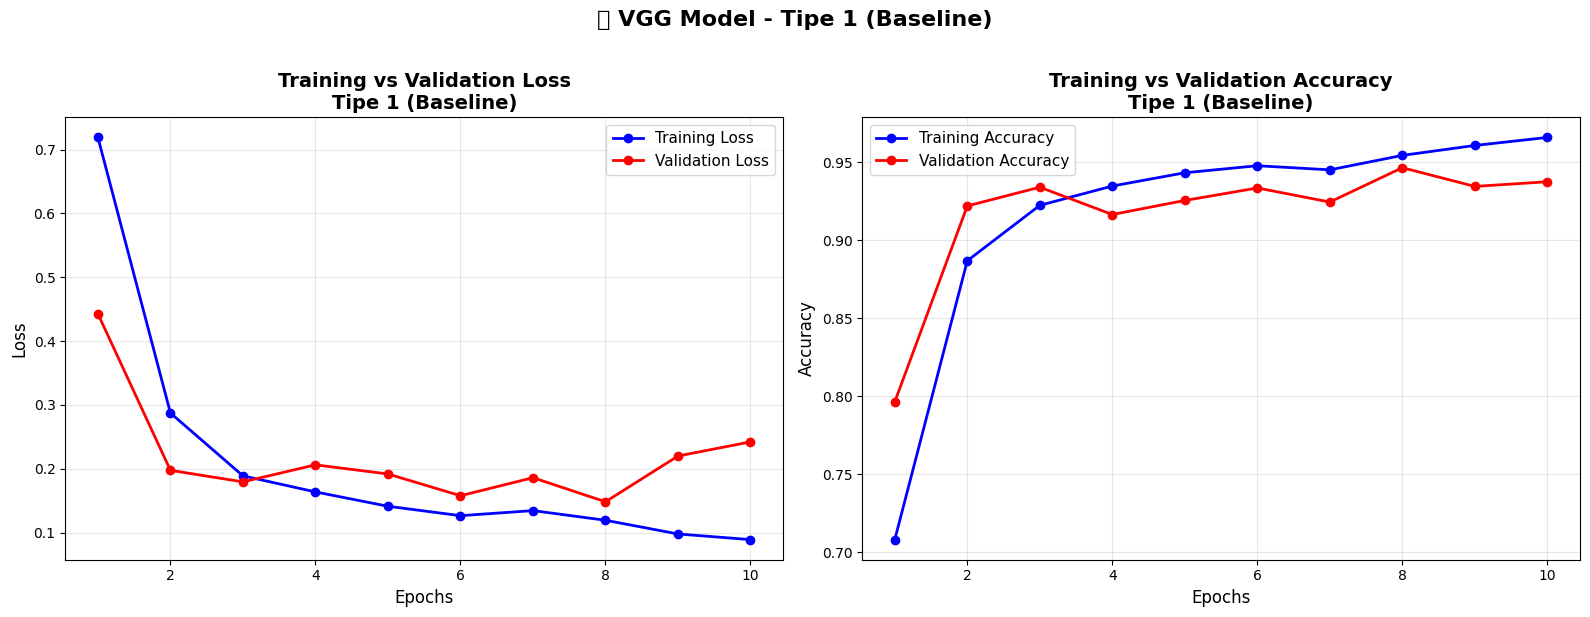


📊 SUMMARY HASIL TRAINING - TIPE 1
Epochs: 10 | Batch Size: 32 | LR: 0.001
------------------------------------------------------------
Final Training Loss      : 0.0891
Final Training Accuracy  : 0.9659 (96.59%)
Final Validation Loss    : 0.2422
Final Validation Accuracy: 0.9375 (93.75%)
Training Duration        : 47.32s (0.79 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [25]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type1 = history_type1.history['loss']
val_loss_values_type1 = history_type1.history['val_loss']
accuracy_values_type1 = history_type1.history['accuracy']
val_accuracy_values_type1 = history_type1.history['val_accuracy']

epochs_range = range(1, len(loss_values_type1) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type1, 'bo-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type1, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 1 (Baseline)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type1, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type1, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 1 (Baseline)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('🔵 VGG Model - Tipe 1 (Baseline)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - TIPE 1")
print("="*60)
print(f"Epochs: {epochs_type1} | Batch Size: {batch_size_type1} | LR: {learning_rate_type1}")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type1[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type1[-1]:.4f} ({accuracy_values_type1[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type1[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type1[-1]:.4f} ({val_accuracy_values_type1[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type1:.2f}s ({training_duration_type1/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type1[-1] - val_accuracy_values_type1[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

In [26]:
print("="*60)
print("📈 EVALUASI MODEL - TIPE 1")
print("="*60)

# Evaluate pada validation set
loss_type1, accuracy_type1 = model_type1.evaluate(val_images, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - TIPE 1")
print("="*60)
print(f"Validation Loss    : {loss_type1:.4f}")
print(f"Validation Accuracy: {accuracy_type1:.4f} ({accuracy_type1*100:.2f}%)")
print("="*60)

# Interpretasi hasil
if accuracy_type1 > 0.85:
    print("\n✅ Model Tipe 1 memiliki performa BAIK!")
elif accuracy_type1 > 0.75:
    print("\n⚠️  Model Tipe 1 cukup baik, masih bisa ditingkatkan.")
else:
    print("\n❌ Model Tipe 1 perlu perbaikan.")

📈 EVALUASI MODEL - TIPE 1
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9379 - loss: 0.2149

📊 HASIL EVALUASI FINAL - TIPE 1
Validation Loss    : 0.2422
Validation Accuracy: 0.9375 (93.75%)

✅ Model Tipe 1 memiliki performa BAIK!


## VGG - Tipe 2

### Build Model

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definisi ukuran input (Height, Width, Channels)
input_shape = (64, 64, 3)

print("="*60)
print("🟢 VGG TIPE 2 - OPTIMIZED (Better Convergence)")
print("="*60)
print("Membangun arsitektur VGG-like model...")

# Bangun model VGG menggunakan Sequential API
model_type2 = models.Sequential([

    # === BLOCK 1 ===
    # Conv layer pertama: ekstrak fitur dasar (edges, corners)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    # Conv layer kedua: pelajari fitur lebih kompleks dari block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # MaxPooling: ambil fitur paling dominan, kurangi dimensi spatial (64x64 -> 32x32)
    layers.MaxPooling2D((2, 2)),

    # === BLOCK 2 ===
    # Filter ditingkatkan jadi 64 untuk tangkap fitur lebih kompleks
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    # MaxPooling: kurangi dimensi lagi (32x32 -> 16x16)
    layers.MaxPooling2D((2, 2)),

    # === BLOCK 3 ===
    # Filter ditingkatkan jadi 128 untuk fitur high-level
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    # MaxPooling: dimensi akhir (16x16 -> 8x8)
    layers.MaxPooling2D((2, 2)),

    # === FULLY CONNECTED LAYERS ===
    # Flatten: ubah output 3D (8x8x128) menjadi 1D vector (8192 neuron)
    layers.Flatten(),

    # Dense layer: gabungkan semua fitur untuk klasifikasi
    # 512 neuron dengan ReLU activation
    layers.Dense(512, activation='relu'),

    # Dropout: randomly matikan 50% neuron saat training untuk cegah overfitting
    layers.Dropout(0.5),

    # Output layer: 1 neuron untuk binary classification (Male/Female)
    # Sigmoid: output probabilitas antara 0 dan 1
    layers.Dense(1, activation='sigmoid')
])

# Tampilkan arsitektur model
print("\n=== Arsitektur Model VGG Tipe 2 ===")
model_type2.summary()
print(f"\nTotal parameter: {model_type2.count_params():,}")
print("="*60)

🟢 VGG TIPE 2 - OPTIMIZED (Better Convergence)
Membangun arsitektur VGG-like model...

=== Arsitektur Model VGG Tipe 2 ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,629,921 (17.66 MB)

 Trainable params: 4,629,921 (17.66 MB)

 Non-trainable params: 0 (0.00 B)


Total parameter: 4,629,921


### Compile Model

In [29]:
from tensorflow.keras.optimizers import Adam

# === KONFIGURASI TIPE 2 ===
config_name = "Optimized - Better Convergence"
learning_rate_type2 = 0.0001  # Learning rate lebih kecil

print("="*60)
print("🟢 COMPILE MODEL - TIPE 2")
print("="*60)
print(f"Konfigurasi: {config_name}")
print(f"Learning Rate: {learning_rate_type2}")
print(f"Optimizer: Adam")
print(f"Loss Function: Binary Crossentropy")
print("="*60)

print("\n📌 REASONING TIPE 2 (Optimized):")
print("-"*60)
print("""
- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Learning rate lebih kecil = fine-tuning lebih halus
  → Mencegah overshoot saat mendekati konvergensi
  → Membantu model tidak "melompat" keluar dari local minima yang bagus
  → Trade-off: butuh epochs lebih banyak untuk konvergen

- Optimizer: Adam
  → Tetap pakai Adam karena terbukti robust
  → Adaptive learning rate membantu dengan LR kecil
  → Kombinasi momentum + adaptive learning

- Loss: Binary Crossentropy
  → Sama dengan Tipe 1, standard untuk binary classification

✅ TUJUAN: Mencari performance maksimal dengan konvergensi lebih halus
""")
print("="*60)

# Compile model
model_type2.compile(
    optimizer=Adam(learning_rate=learning_rate_type2),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model Tipe 2 berhasil dikompilasi!")

🟢 COMPILE MODEL - TIPE 2
Konfigurasi: Optimized - Better Convergence
Learning Rate: 0.0001
Optimizer: Adam
Loss Function: Binary Crossentropy

📌 REASONING TIPE 2 (Optimized):
------------------------------------------------------------

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Learning rate lebih kecil = fine-tuning lebih halus
  → Mencegah overshoot saat mendekati konvergensi
  → Membantu model tidak "melompat" keluar dari local minima yang bagus
  → Trade-off: butuh epochs lebih banyak untuk konvergen

- Optimizer: Adam
  → Tetap pakai Adam karena terbukti robust
  → Adaptive learning rate membantu dengan LR kecil
  → Kombinasi momentum + adaptive learning

- Loss: Binary Crossentropy
  → Sama dengan Tipe 1, standard untuk binary classification

✅ TUJUAN: Mencari performance maksimal dengan konvergensi lebih halus


✅ Model Tipe 2 berhasil dikompilasi!


### Train Model

In [30]:
import time

# === KONFIGURASI TRAINING TIPE 2 ===
epochs_type2 = 20  # 2x lebih banyak dari Tipe 1
batch_size_type2 = 64  # 2x lebih besar dari Tipe 1

print("="*60)
print("🚀 TRAINING MODEL - TIPE 2")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type2}")
print(f"Batch Size: {batch_size_type2}")
print(f"Learning Rate: {learning_rate_type2}")
print("-"*60)
print(f"Total training samples: {len(train_images):,}")
print(f"Total validation samples: {len(val_images):,}")
print(f"Steps per epoch: {len(train_images) // batch_size_type2}")
print(f"Total steps: {(len(train_images) // batch_size_type2) * epochs_type2}")
print("="*60)

print("\n📌 REASONING HYPERPARAMETER TIPE 2:")
print("-"*60)
print("""
- Epochs: 20 (2x dari Tipe 1)
  → Lebih banyak iterasi untuk model belajar pattern lebih dalam
  → Memberi kesempatan model untuk konvergen lebih baik
  → Karena LR kecil, butuh lebih banyak epochs

- Batch Size: 64 (2x dari Tipe 1)
  → Batch lebih besar = gradient update lebih stabil
  → Mengurangi noise dalam training process
  → Lebih efficient dalam GPU utilization
  → Trade-off: butuh memory lebih besar, update lebih jarang

- Kombinasi: LR kecil + Batch besar + Epochs banyak
  → Strategi untuk konvergensi halus dan stabil
  → Mencari global minima lebih optimal

✅ COCOK UNTUK: Production model, maximum accuracy, fine-tuning
""")
print("="*60)

# Catat waktu mulai training
start_time = time.time()

# Train model
history_type2 = model_type2.fit(
    train_images,
    train_labels,
    epochs=epochs_type2,
    batch_size=batch_size_type2,
    validation_data=(val_images, val_labels),
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_type2 = end_time - start_time

print("\n" + "="*60)
print("✅ TRAINING TIPE 2 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_type2:.2f} detik ({training_duration_type2/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_type2.history['accuracy'][-1]:.4f} ({history_type2.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_type2.history['val_accuracy'][-1]:.4f} ({history_type2.history['val_accuracy'][-1]*100:.2f}%)")
print("="*60)

🚀 TRAINING MODEL - TIPE 2
Konfigurasi: Optimized - Better Convergence
------------------------------------------------------------
Epochs: 20
Batch Size: 64
Learning Rate: 0.0001
------------------------------------------------------------
Total training samples: 8,000
Total validation samples: 2,000
Steps per epoch: 125
Total steps: 2500

📌 REASONING HYPERPARAMETER TIPE 2:
------------------------------------------------------------

- Epochs: 20 (2x dari Tipe 1)
  → Lebih banyak iterasi untuk model belajar pattern lebih dalam
  → Memberi kesempatan model untuk konvergen lebih baik
  → Karena LR kecil, butuh lebih banyak epochs

- Batch Size: 64 (2x dari Tipe 1)
  → Batch lebih besar = gradient update lebih stabil
  → Mengurangi noise dalam training process
  → Lebih efficient dalam GPU utilization
  → Trade-off: butuh memory lebih besar, update lebih jarang

- Kombinasi: LR kecil + Batch besar + Epochs banyak
  → Strategi untuk konvergensi halus dan stabil
  → Mencari global minima l

### Plot Training History

/tmp/ipython-input-3892232355.py:33: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


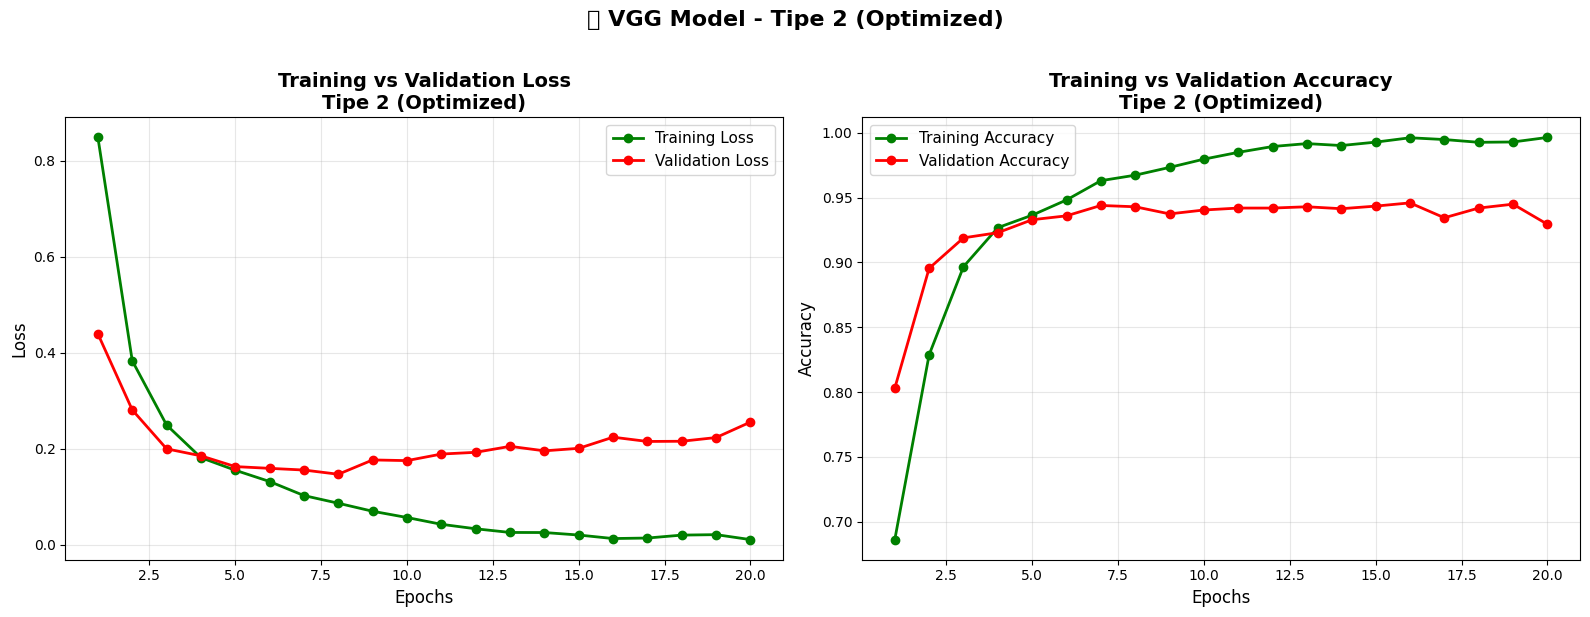


📊 SUMMARY HASIL TRAINING - TIPE 2
Epochs: 20 | Batch Size: 64 | LR: 0.0001
------------------------------------------------------------
Final Training Loss      : 0.0106
Final Training Accuracy  : 0.9965 (99.65%)
Final Validation Loss    : 0.2554
Final Validation Accuracy: 0.9295 (92.95%)
Training Duration        : 82.58s (1.38 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [31]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type2 = history_type2.history['loss']
val_loss_values_type2 = history_type2.history['val_loss']
accuracy_values_type2 = history_type2.history['accuracy']
val_accuracy_values_type2 = history_type2.history['val_accuracy']

epochs_range = range(1, len(loss_values_type2) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type2, 'go-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type2, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 2 (Optimized)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type2, 'go-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type2, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 2 (Optimized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('🟢 VGG Model - Tipe 2 (Optimized)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - TIPE 2")
print("="*60)
print(f"Epochs: {epochs_type2} | Batch Size: {batch_size_type2} | LR: {learning_rate_type2}")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type2[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type2[-1]:.4f} ({accuracy_values_type2[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type2[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type2[-1]:.4f} ({val_accuracy_values_type2[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type2:.2f}s ({training_duration_type2/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type2[-1] - val_accuracy_values_type2[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

In [32]:
print("="*60)
print("📈 EVALUASI MODEL - TIPE 2")
print("="*60)

# Evaluate pada validation set
loss_type2, accuracy_type2 = model_type2.evaluate(val_images, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - TIPE 2")
print("="*60)
print(f"Validation Loss    : {loss_type2:.4f}")
print(f"Validation Accuracy: {accuracy_type2:.4f} ({accuracy_type2*100:.2f}%)")
print("="*60)

# Interpretasi hasil
if accuracy_type2 > 0.85:
    print("\n✅ Model Tipe 2 memiliki performa BAIK!")
elif accuracy_type2 > 0.75:
    print("\n⚠️  Model Tipe 2 cukup baik, masih bisa ditingkatkan.")
else:
    print("\n❌ Model Tipe 2 perlu perbaikan.")

📈 EVALUASI MODEL - TIPE 2
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9264 - loss: 0.2668

📊 HASIL EVALUASI FINAL - TIPE 2
Validation Loss    : 0.2554
Validation Accuracy: 0.9295 (92.95%)

✅ Model Tipe 2 memiliki performa BAIK!


## Test (V1 + V2)

🔵🟢 TEST PREDIKSI - KEDUA MODEL SEKALIGUS
Upload gambar sekali, test di Model Tipe 1 & Tipe 2
------------------------------------------------------------


Saving LUCINTA.webp to LUCINTA (1).webp

📷 Memproses gambar: "LUCINTA (1).webp"
Ukuran file: 6,030 bytes

📊 HASIL PREDIKSI UNTUK: LUCINTA (1).webp
🔵 MODEL TIPE 1 (Baseline):
   Prediksi: Male
   Prob Male: 0.5560 (55.60%)
   Confidence: 0.5560 (55.60%)

🟢 MODEL TIPE 2 (Optimized):
   Prediksi: Female
   Prob Male: 0.4987 (49.87%)
   Confidence: 0.5013 (50.13%)

⚠️  PREDIKSI BERBEDA!
   Tipe 1: Male (55.60%)
   Tipe 2: Female (50.13%)


/tmp/ipython-input-1441573830.py:135: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1441573830.py:135: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


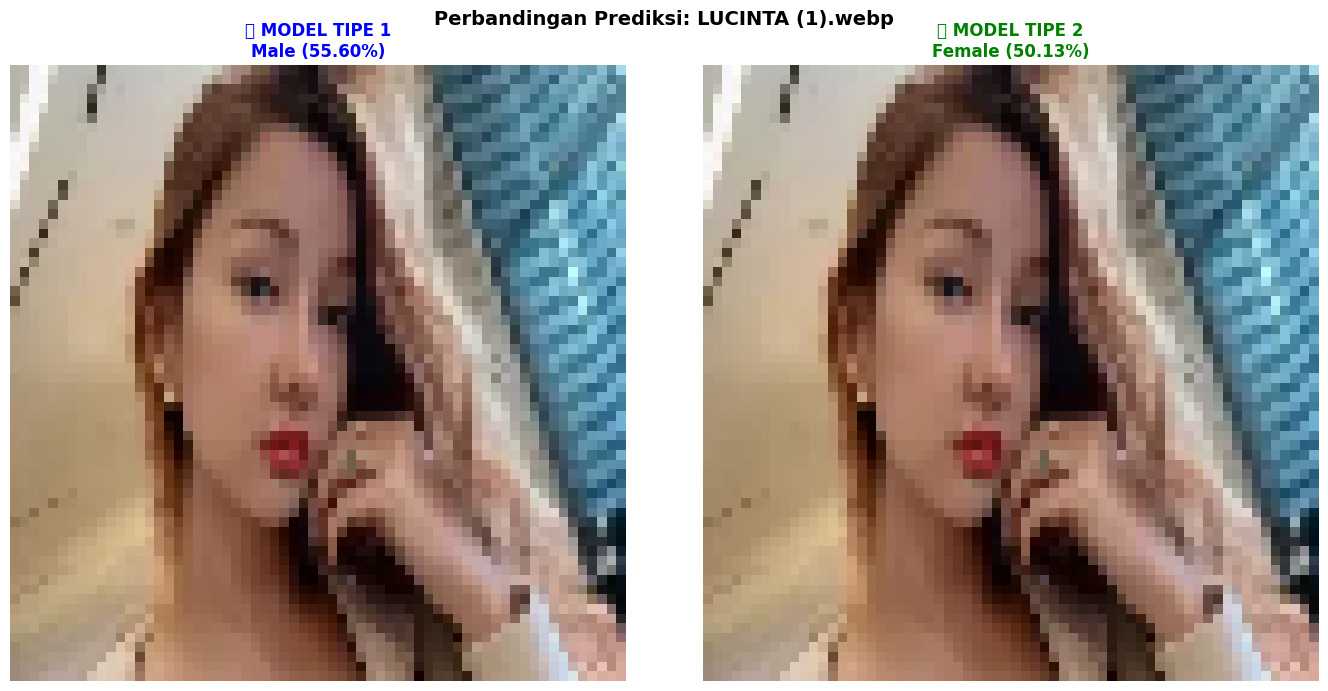


✅ Prediksi kedua model selesai!


In [33]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("🔵🟢 TEST PREDIKSI - KEDUA MODEL SEKALIGUS")
print("="*60)
print("Upload gambar sekali, test di Model Tipe 1 & Tipe 2")
print("-"*60)

# Upload gambar dari komputer lokal
uploaded = files.upload()

# Simpan hasil prediksi untuk perbandingan
predictions_comparison = []

# Proses setiap gambar yang diupload
for fn in uploaded.keys():
    print(f'\n{"="*60}')
    print(f'📷 Memproses gambar: "{fn}"')
    print(f'Ukuran file: {len(uploaded[fn]):,} bytes')
    print(f'{"="*60}')

    # Baca gambar
    image_path = fn
    img = cv2.imread(image_path)

    if img is None:
        print(f"❌ Error: Tidak dapat membaca gambar {image_path}")
        continue

    # === PREPROCESSING (SAMA DENGAN TRAINING) ===

    # 1. Resize ke ukuran input model (64x64)
    target_size = (64, 64)
    img_resized = cv2.resize(img, target_size)

    # 2. Konversi BGR (OpenCV) ke RGB (sesuai training)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # 3. Normalisasi: ubah range piksel dari [0, 255] ke [0, 1]
    img_normalized = img_rgb.astype('float32') / 255.0

    # 4. Tambah dimensi batch: (64, 64, 3) -> (1, 64, 64, 3)
    img_input = np.expand_dims(img_normalized, axis=0)

    # === PREDIKSI DENGAN KEDUA MODEL ===
    results = {}

    # Prediksi Model Tipe 1
    if 'model_type1' in globals():
        pred1 = model_type1.predict(img_input, verbose=0)
        prob_male_1 = pred1[0][0]
        class_1 = "Male" if prob_male_1 > 0.5 else "Female"
        conf_1 = prob_male_1 if prob_male_1 > 0.5 else (1 - prob_male_1)
        results['type1'] = {
            'prob_male': prob_male_1,
            'class': class_1,
            'confidence': conf_1
        }
    else:
        print("⚠️  Model Tipe 1 tidak ditemukan, skip prediksi Tipe 1")

    # Prediksi Model Tipe 2
    if 'model_type2' in globals():
        pred2 = model_type2.predict(img_input, verbose=0)
        prob_male_2 = pred2[0][0]
        class_2 = "Male" if prob_male_2 > 0.5 else "Female"
        conf_2 = prob_male_2 if prob_male_2 > 0.5 else (1 - prob_male_2)
        results['type2'] = {
            'prob_male': prob_male_2,
            'class': class_2,
            'confidence': conf_2
        }
    else:
        print("⚠️  Model Tipe 2 tidak ditemukan, skip prediksi Tipe 2")

    # Simpan hasil untuk tabel perbandingan
    if 'type1' in results and 'type2' in results:
        predictions_comparison.append({
            'filename': fn,
            'type1_prob_male': results['type1']['prob_male'],
            'type1_class': results['type1']['class'],
            'type1_conf': results['type1']['confidence'],
            'type2_prob_male': results['type2']['prob_male'],
            'type2_class': results['type2']['class'],
            'type2_conf': results['type2']['confidence']
        })

    # === TAMPILKAN HASIL SIDE-BY-SIDE ===
    print(f"\n📊 HASIL PREDIKSI UNTUK: {fn}")
    print(f"="*60)

    if 'type1' in results:
        print(f"🔵 MODEL TIPE 1 (Baseline):")
        print(f"   Prediksi: {results['type1']['class']}")
        print(f"   Prob Male: {results['type1']['prob_male']:.4f} ({results['type1']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type1']['confidence']:.4f} ({results['type1']['confidence']*100:.2f}%)")

    if 'type2' in results:
        print(f"\n🟢 MODEL TIPE 2 (Optimized):")
        print(f"   Prediksi: {results['type2']['class']}")
        print(f"   Prob Male: {results['type2']['prob_male']:.4f} ({results['type2']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type2']['confidence']:.4f} ({results['type2']['confidence']*100:.2f}%)")

    # Cek apakah prediksi sama atau beda
    if 'type1' in results and 'type2' in results:
        if results['type1']['class'] == results['type2']['class']:
            print(f"\n✅ KEDUA MODEL SEPAKAT: {results['type1']['class']}")
        else:
            print(f"\n⚠️  PREDIKSI BERBEDA!")
            print(f"   Tipe 1: {results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)")
            print(f"   Tipe 2: {results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)")

    print(f"="*60)

    # === VISUALISASI SIDE-BY-SIDE ===
    if 'type1' in results and 'type2' in results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Model Tipe 1
        axes[0].imshow(img_rgb)
        axes[0].set_title(f"🔵 MODEL TIPE 1\n{results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='blue')
        axes[0].axis('off')

        # Model Tipe 2
        axes[1].imshow(img_rgb)
        axes[1].set_title(f"🟢 MODEL TIPE 2\n{results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='green')
        axes[1].axis('off')

        plt.suptitle(f"Perbandingan Prediksi: {fn}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

print("\n" + "="*60)
print("✅ Prediksi kedua model selesai!")
print("="*60)

# GoogleNet

## Setup Kaggle di Colab

In [2]:
# Install Kaggle
!pip install kaggle -q
import os
import sys

# Buat direktori .kaggle jika belum ada
!mkdir -p ~/.kaggle

# Cek apakah file kaggle.json sudah diupload
if os.path.exists('/content/kaggle.json'):
    # Pindahkan kaggle.json ke direktori .kaggle
    !mv /content/kaggle.json ~/.kaggle/
    # Set permission file agar secure
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json berhasil dikonfigurasi.")
else:
    print("kaggle.json tidak ditemukan di /content/. Silakan upload file kaggle.json terlebih dahulu.")

kaggle.json berhasil dikonfigurasi.


## Download Dataset dari Kaggle

In [3]:
# Download dataset CelebA 64x64 dari Kaggle
!kaggle datasets download -d therealcyberlord/50k-celeba-dataset-64x64

Dataset URL: https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64
License(s): unknown
  0% 0.00/78.1M [00:00<?, ?B/s]
100% 78.1M/78.1M [00:00<00:00, 1.72GB/s]


## Extract Dataset

In [5]:
import zipfile
import os

# Path file zip yang telah didownload
zip_file_path = '/content/50k-celeba-dataset-64x64.zip'

# Direktori tujuan ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'

# Buat folder ekstraksi jika belum ada
os.makedirs(extracted_path, exist_ok=True)

# Ekstrak file zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Dataset berhasil diekstrak.")
except FileNotFoundError:
    print(f"Error: File {zip_file_path} tidak ditemukan. Pastikan download berhasil.")
except zipfile.BadZipFile:
    print(f"Error: File {zip_file_path} bukan zip yang valid. Download mungkin corrupt.")
except Exception as e:
    print(f"Error saat ekstraksi: {e}")

Dataset berhasil diekstrak.


## Cek Isi Folder

In [6]:
import os

# Tampilkan isi direktori hasil ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'
print("Isi folder ekstraksi:")
print(os.listdir(extracted_path))

Isi folder ekstraksi:
['50k']


## Download Attribute File (Label)

In [7]:
# Download file atribut dari GitHub (alternatif jika gagal)
# Opsional: Bisa juga download manual dari Google Drive
# Link Google Drive: https://drive.google.com/drive/folders/1AA21MR8GeQdnOVgmNcbxCrbAjL1udj0l

import requests
import os

# URL file atribut CelebA
attribute_file_url = "https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt"
attribute_file_path = "/content/list_attr_celeba.txt"

print(f"Mencoba download file atribut dari: {attribute_file_url}")

try:
    response = requests.get(attribute_file_url, stream=True)
    response.raise_for_status()  # Raise error jika status 4xx atau 5xx

    with open(attribute_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"File atribut berhasil didownload ke: {attribute_file_path}")

except requests.exceptions.RequestException as e:
    print(f"Error saat download file atribut: {e}")
    print("Tidak dapat mendownload file dari URL yang diberikan.")
    print("Silakan download manual dari Google Drive dan upload ke Colab.")
except Exception as e:
    print(f"Error saat memproses file atribut: {e}")

Mencoba download file atribut dari: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Error saat download file atribut: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Tidak dapat mendownload file dari URL yang diberikan.
Silakan download manual dari Google Drive dan upload ke Colab.


## Load Gambar ke Numpy

In [8]:
import os
import cv2
import numpy as np

# Direktori tempat gambar hasil ekstraksi
image_dir = '/content/celeba_dataset_kaggle/50k'

# Ukuran target gambar (dataset sudah 64x64)
image_size = (64, 64)

# List semua file gambar (format .jpg atau .png)
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Batasi jumlah gambar untuk eksperimen awal (opsional)
# Bisa dihapus atau diubah untuk load seluruh dataset
num_images_to_load = 10000  # Load 10,000 gambar
image_files = image_files[:num_images_to_load]

print(f"Memulai loading {len(image_files)} gambar...")

# Load dan preprocess gambar
images = []
for idx, file_name in enumerate(image_files):
    img_path = os.path.join(image_dir, file_name)
    img = cv2.imread(img_path)

    if img is not None:
        # Konversi dari BGR (OpenCV default) ke RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize jika ukuran tidak sesuai (meskipun dataset sudah 64x64)
        if img.shape[:2] != image_size:
            img = cv2.resize(img, image_size)

        images.append(img)
    else:
        print(f"Warning: Tidak dapat membaca gambar {img_path}")

    # Progress indicator setiap 1000 gambar
    if (idx + 1) % 1000 == 0:
        print(f"Progress: {idx + 1}/{len(image_files)} gambar diload")

# Konversi list ke NumPy array
images = np.array(images)

print(f"\n{'='*60}")
print("✅ BERHASIL LOAD GAMBAR")
print(f"{'='*60}")
print(f"Total gambar diload: {len(images)}")
print(f"Shape array gambar: {images.shape}")
print(f"Tipe data: {images.dtype}")
print(f"Range nilai piksel: [{images.min()}, {images.max()}]")
print(f"Variabel 'image_files' tersimpan: {len(image_files)} filenames")
print(f"{'='*60}")

Memulai loading 10000 gambar...
Progress: 1000/10000 gambar diload
Progress: 2000/10000 gambar diload
Progress: 3000/10000 gambar diload
Progress: 4000/10000 gambar diload
Progress: 5000/10000 gambar diload
Progress: 6000/10000 gambar diload
Progress: 7000/10000 gambar diload
Progress: 8000/10000 gambar diload
Progress: 9000/10000 gambar diload
Progress: 10000/10000 gambar diload

✅ BERHASIL LOAD GAMBAR
Total gambar diload: 10000
Shape array gambar: (10000, 64, 64, 3)
Tipe data: uint8
Range nilai piksel: [0, 255]
Variabel 'image_files' tersimpan: 10000 filenames


## Load Attribute File

In [9]:
import pandas as pd
import numpy as np
import os

# Path file atribut yang sudah diupload
attribute_file_path = '/content/list_attr_celeba.txt'

print("Memulai loading file atribut...")
print(f"{'='*60}")

if os.path.exists(attribute_file_path):
    print(f"✅ File atribut ditemukan di: {attribute_file_path}")

    # Load file atribut CelebA
    # Format: baris pertama = jumlah data, baris kedua = nama kolom
    # Skip 1 baris pertama, gunakan regex untuk separator (bisa multiple spaces)
    attributes_df = pd.read_csv(attribute_file_path, sep=r'\s+', skiprows=1)

    # Tampilkan 5 baris pertama untuk verifikasi
    print("\n📋 Preview Data Atribut:")
    display(attributes_df.head())

    # Pastikan variabel 'image_files' sudah ada dari step sebelumnya (load gambar)
    if 'image_files' in globals():
        print(f"\n✅ Variabel 'image_files' ditemukan ({len(image_files)} files)")

        # Ambil nama file gambar yang sudah diload (tanpa path)
        loaded_image_filenames = [os.path.basename(f) for f in image_files]

        # Pastikan index dataframe bertipe string untuk matching dengan filename
        attributes_df.index = attributes_df.index.astype(str)

        # Ambil kolom 'Male' sebagai label
        # Nilai: -1 = Female, 1 = Male
        if 'Male' in attributes_df.columns:
            # Reindex untuk mencocokkan urutan gambar yang diload
            loaded_attributes = attributes_df.reindex(loaded_image_filenames)

            # Ekstrak kolom 'Male' dan konversi -1 menjadi 0 (Female=0, Male=1)
            # Handle NaN values dengan fillna(-1) jika ada gambar tanpa label
            male_labels = loaded_attributes['Male'].fillna(-1).replace(-1, 0).values

            # Cek apakah jumlah label cocok dengan jumlah gambar
            if len(male_labels) != len(images):
                print(f"\n⚠️ Peringatan: Jumlah label ({len(male_labels)}) tidak cocok dengan jumlah gambar ({len(images)}).")
                print("Mungkin ada gambar yang tidak memiliki label.")

            print(f"\n{'='*60}")
            print("✅ BERHASIL LOAD LABEL")
            print(f"{'='*60}")
            print(f"Total label diload: {len(male_labels)}")
            print(f"Shape array label: {male_labels.shape}")
            print(f"Contoh 10 label pertama: {male_labels[:10]}")
            print(f"Distribusi: Female={int((male_labels == 0).sum())}, Male={int((male_labels == 1).sum())}")
            print(f"{'='*60}")

        else:
            print("❌ Kolom 'Male' tidak ditemukan dalam file atribut.")
            male_labels = None

    else:
        print("\n❌ Error: Variabel 'image_files' tidak ditemukan.")
        print("⚠️ PASTIKAN SUDAH MENJALANKAN STEP 6 (Load Gambar) TERLEBIH DAHULU!")
        attributes_df = None
        male_labels = None

else:
    print(f"❌ File atribut ({attribute_file_path}) tidak ditemukan.")
    print("📥 Silakan upload file 'list_attr_celeba.txt' ke direktori /content/")
    print("   Download dari: https://drive.google.com/drive/folders/1AA21MR8GeQdnOVgmNcbxCrbAjL1udj0l")
    male_labels = None

# Validasi akhir: set male_labels ke None jika ada masalah
if 'male_labels' in locals() and male_labels is not None and 'images' in globals() and len(male_labels) == len(images):
    print("\n✅ Data gambar dan label siap digunakan!")
else:
    if 'male_labels' not in locals() or male_labels is None:
        print("\n❌ Gagal load label. Setting male_labels = None.")
        male_labels = None
    elif 'images' not in globals():
        print("\n❌ Variabel 'images' tidak ditemukan. Jalankan Step 6 terlebih dahulu.")
        male_labels = None
    elif len(male_labels) != len(images):
        print(f"\n❌ Jumlah tidak cocok (images: {len(images)}, labels: {len(male_labels)}). Setting male_labels = None.")
        male_labels = None

Memulai loading file atribut...
✅ File atribut ditemukan di: /content/list_attr_celeba.txt

📋 Preview Data Atribut:


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1



✅ Variabel 'image_files' ditemukan (10000 files)

✅ BERHASIL LOAD LABEL
Total label diload: 10000
Shape array label: (10000,)
Contoh 10 label pertama: [0 0 0 1 0 0 0 0 1 0]
Distribusi: Female=5876, Male=4124

✅ Data gambar dan label siap digunakan!


## Split Data menjadi Training dan Validation

In [10]:
from sklearn.model_selection import train_test_split

# === VALIDASI DATA SEBELUM SPLIT ===
print("Memeriksa ketersediaan data...")

# Cek apakah images sudah diload
if 'images' not in globals() or images is None:
    print("❌ Error: Variabel 'images' tidak ditemukan atau kosong!")
    print("Pastikan sudah menjalankan cell 'Load Gambar ke Numpy' terlebih dahulu.")
    train_images, val_images, train_labels, val_labels = None, None, None, None

# Cek apakah male_labels sudah diload
elif 'male_labels' not in globals() or male_labels is None:
    print("❌ Error: Variabel 'male_labels' tidak ditemukan atau kosong!")
    print("Pastikan sudah menjalankan cell 'Load Attribute File' terlebih dahulu.")
    print("File 'list_attr_celeba.txt' harus sudah diupload ke /content/")
    train_images, val_images, train_labels, val_labels = None, None, None, None

# Cek apakah jumlah gambar dan label cocok
elif len(images) != len(male_labels):
    print(f"❌ Error: Jumlah gambar ({len(images)}) dan label ({len(male_labels)}) tidak cocok!")
    print("Periksa kembali proses loading data.")
    train_images, val_images, train_labels, val_labels = None, None, None, None

# Jika semua validasi lolos, lakukan split
else:
    print(f"✅ Jumlah gambar ({len(images)}) dan label ({len(male_labels)}) cocok.")
    print("Melanjutkan split data...")

    # Split data: 80% training, 20% validation
    # stratify digunakan untuk menjaga distribusi kelas (Male/Female) tetap seimbang
    train_images, val_images, train_labels, val_labels = train_test_split(
        images,
        male_labels,
        test_size=0.2,      # 20% untuk validation
        random_state=42,    # Untuk reproducibility
        stratify=male_labels # Jaga keseimbangan kelas
    )

    print(f"\n{'='*60}")
    print("=== Hasil Split Data ===")
    print(f"{'='*60}")
    print(f"Training images shape   : {train_images.shape}")
    print(f"Validation images shape : {val_images.shape}")
    print(f"Training labels shape   : {train_labels.shape}")
    print(f"Validation labels shape : {val_labels.shape}")

    # Tampilkan distribusi kelas
    print(f"\n{'='*60}")
    print("=== Distribusi Kelas ===")
    print(f"{'='*60}")
    train_female = (train_labels == 0).sum()
    train_male = (train_labels == 1).sum()
    val_female = (val_labels == 0).sum()
    val_male = (val_labels == 1).sum()

    print(f"Training Set:")
    print(f"  - Female: {train_female} ({train_female/len(train_labels)*100:.2f}%)")
    print(f"  - Male  : {train_male} ({train_male/len(train_labels)*100:.2f}%)")
    print(f"\nValidation Set:")
    print(f"  - Female: {val_female} ({val_female/len(val_labels)*100:.2f}%)")
    print(f"  - Male  : {val_male} ({val_male/len(val_labels)*100:.2f}%)")
    print(f"{'='*60}")

    # === NORMALISASI GAMBAR ===
    print("\n🔄 Normalisasi gambar...")
    print("Mengubah range piksel dari [0, 255] → [0, 1]")

    train_images = train_images.astype('float32') / 255.0
    val_images = val_images.astype('float32') / 255.0

    print(f"✅ Normalisasi selesai!")
    print(f"Training images - min: {train_images.min():.1f}, max: {train_images.max():.1f}")
    print(f"Validation images - min: {val_images.min():.1f}, max: {val_images.max():.1f}")
    print(f"{'='*60}")

    print("\n✅ Split data dan normalisasi berhasil!")

Memeriksa ketersediaan data...
✅ Jumlah gambar (10000) dan label (10000) cocok.
Melanjutkan split data...

=== Hasil Split Data ===
Training images shape   : (8000, 64, 64, 3)
Validation images shape : (2000, 64, 64, 3)
Training labels shape   : (8000,)
Validation labels shape : (2000,)

=== Distribusi Kelas ===
Training Set:
  - Female: 4701 (58.76%)
  - Male  : 3299 (41.24%)

Validation Set:
  - Female: 1175 (58.75%)
  - Male  : 825 (41.25%)

🔄 Normalisasi gambar...
Mengubah range piksel dari [0, 255] → [0, 1]
✅ Normalisasi selesai!
Training images - min: 0.0, max: 1.0
Validation images - min: 0.0, max: 1.0

✅ Split data dan normalisasi berhasil!


## GoogleNet - V1

### Build Model GoogleNet

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definisi ukuran input (Height, Width, Channels)
input_shape = (64, 64, 3)

print("="*60)
print("🔵 GOOGLENET TIPE 1 - LIGHTWEIGHT (Quick Training)")
print("="*60)

# === DEFINISI INCEPTION MODULE ===
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3,
                     filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """
    Inception Module: Inti dari arsitektur GoogleNet

    Berbeda dengan VGG yang hanya pakai kernel 3x3 bertumpuk,
    Inception module menggabungkan beberapa ukuran kernel (1x1, 3x3, 5x5)
    secara paralel untuk menangkap fitur di berbagai skala.

    Keuntungan:
    - Parameter lebih sedikit dari VGG
    - Lebih efisien secara komputasi
    - Bisa tangkap fitur multi-scale sekaligus
    """
    # Path 1: Konvolusi 1x1
    # Fungsi: Reduksi dimensi channel, menangkap fitur point-wise
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # Path 2: Konvolusi 1x1 → 3x3
    # 1x1 dulu untuk reduksi dimensi, baru 3x3 untuk ekstraksi fitur spatial
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    # Path 3: Konvolusi 1x1 → 5x5
    # Untuk menangkap fitur dengan receptive field lebih besar
    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # Path 4: MaxPooling → 1x1
    # Untuk preserve informasi spatial lewat pooling
    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Gabungkan semua path (concatenate di channel axis)
    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return output

# === BUILD GOOGLENET MODEL ===
print("Membangun arsitektur GoogleNet...")

input_layer = layers.Input(shape=input_shape)

# === LAYER AWAL: Konvolusi dan Pooling ===
# Ekstraksi fitur dasar sebelum masuk Inception modules
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# === INCEPTION MODULES: Inti GoogleNet ===
# Menggunakan Inception module untuk ekstraksi fitur multi-scale

# Inception Block 3
x = inception_module(x, 64, 96, 128, 16, 32, 32)   # 3a
x = inception_module(x, 128, 128, 192, 32, 96, 64) # 3b
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception Block 4
x = inception_module(x, 192, 96, 208, 16, 48, 64)   # 4a
x = inception_module(x, 160, 112, 224, 24, 64, 64)  # 4b
x = inception_module(x, 128, 128, 256, 24, 64, 64)  # 4c
x = inception_module(x, 112, 144, 288, 32, 64, 64)  # 4d
x = inception_module(x, 256, 160, 320, 32, 128, 128) # 4e
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception Block 5
x = inception_module(x, 256, 160, 320, 32, 128, 128) # 5a
x = inception_module(x, 384, 192, 384, 48, 128, 128) # 5b

# === LAYER AKHIR ===
# GlobalAveragePooling: alternatif Flatten yang lebih efisien
# Mengurangi parameter dibanding Flatten + Dense
x = layers.GlobalAveragePooling2D()(x)

# Dropout: Cegah overfitting dengan randomly matikan neuron saat training
x = layers.Dropout(0.4)(x)

# Output layer: Binary classification (Male/Female)
# Sigmoid: output probabilitas 0-1
output_layer = layers.Dense(1, activation='sigmoid', name='main_output')(x)

# Buat model
model_type1 = models.Model(inputs=input_layer, outputs=output_layer)

# Tampilkan arsitektur model
print("\n=== Arsitektur Model GoogleNet Tipe 1 ===")
model_type1.summary()
print(f"\nTotal parameter: {model_type1.count_params():,}")
print("="*60)

🔵 GOOGLENET TIPE 1 - LIGHTWEIGHT (Quick Training)
Membangun arsitektur GoogleNet...

=== Arsitektur Model GoogleNet Tipe 1 ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 192) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 96)  │     18,528 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 16)  │      3,088 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 192) │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     12,352 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │    110,720 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 32)  │     12,832 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 32)  │      6,176 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 256) │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │                   │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 128) │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 8, 8, 32)  │      8,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 128) │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 8, 8, 192) │    221,376 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,974,577 (22.79 MB)

 Trainable params: 5,974,577 (22.79 MB)

 Non-trainable params: 0 (0.00 B)


Total parameter: 5,974,577


### Compile Model

In [12]:
from tensorflow.keras.optimizers import Adam

# === KONFIGURASI TIPE 1 - LIGHTWEIGHT ===
config_name = "Lightweight - Quick Training"
learning_rate_type1 = 0.001  # Learning rate standard

print("="*60)
print("🔵 COMPILE MODEL - TIPE 1 (LIGHTWEIGHT)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print(f"Learning Rate: {learning_rate_type1}")
print(f"Optimizer: Adam")
print(f"Loss Function: Binary Crossentropy")
print("="*60)

print("\n📌 REASONING TIPE 1 (Lightweight):")
print("-"*60)
print("""
- Learning Rate: 0.001
  → Learning rate standard untuk quick training
  → Balance antara kecepatan dan stabilitas
  → Cocok untuk validasi awal arsitektur GoogleNet

- Optimizer: Adam
  → Adaptive learning rate, efisien untuk image classification
  → Kombinasi momentum + RMSprop
  → Populer untuk deep learning, converge lebih cepat

- Loss: Binary Crossentropy
  → Standard untuk klasifikasi binary (Male/Female)
  → Mengukur perbedaan prediksi vs ground truth

✅ TUJUAN: Quick baseline dengan GoogleNet, validasi arsitektur
""")
print("="*60)

# Compile model
model_type1.compile(
    optimizer=Adam(learning_rate=learning_rate_type1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model GoogleNet Tipe 1 berhasil dikompilasi!")

🔵 COMPILE MODEL - TIPE 1 (LIGHTWEIGHT)
Konfigurasi: Lightweight - Quick Training
Learning Rate: 0.001
Optimizer: Adam
Loss Function: Binary Crossentropy

📌 REASONING TIPE 1 (Lightweight):
------------------------------------------------------------

- Learning Rate: 0.001
  → Learning rate standard untuk quick training
  → Balance antara kecepatan dan stabilitas
  → Cocok untuk validasi awal arsitektur GoogleNet

- Optimizer: Adam
  → Adaptive learning rate, efisien untuk image classification
  → Kombinasi momentum + RMSprop
  → Populer untuk deep learning, converge lebih cepat

- Loss: Binary Crossentropy
  → Standard untuk klasifikasi binary (Male/Female)
  → Mengukur perbedaan prediksi vs ground truth

✅ TUJUAN: Quick baseline dengan GoogleNet, validasi arsitektur


✅ Model GoogleNet Tipe 1 berhasil dikompilasi!


### Train Model

In [13]:
import time

# === KONFIGURASI TRAINING TIPE 1 ===
epochs_type1 = 10
batch_size_type1 = 32

print("="*60)
print("🚀 TRAINING MODEL GOOGLENET - TIPE 1")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type1}")
print(f"Batch Size: {batch_size_type1}")
print(f"Learning Rate: {learning_rate_type1}")
print("-"*60)
print(f"Total training samples: {len(train_images):,}")
print(f"Total validation samples: {len(val_images):,}")
print(f"Steps per epoch: {len(train_images) // batch_size_type1}")
print(f"Total steps: {(len(train_images) // batch_size_type1) * epochs_type1}")
print("="*60)

print("\n📌 REASONING HYPERPARAMETER TIPE 1:")
print("-"*60)
print("""
- Epochs: 10
  → Cukup untuk melihat trend awal training GoogleNet
  → Quick experimentation, baseline comparison
  → Tidak terlalu lama untuk resource terbatas

- Batch Size: 32
  → Ukuran batch standard yang balance
  → Memory-friendly untuk GoogleNet yang lebih kompleks dari VGG
  → Update gradient lebih sering = learning lebih dinamis

- GoogleNet vs VGG (Tipe 1):
  → GoogleNet: Inception module, parameter lebih sedikit (~6M vs ~4.6M VGG)
  → GoogleNet: Multi-scale feature extraction (1x1, 3x3, 5x5 paralel)
  → VGG: Simple stacking 3x3, lebih monoton
  → GoogleNet: Lebih efisien, tapi mungkin butuh tuning lebih

✅ COCOK UNTUK: Quick validation, resource-limited scenarios
""")
print("="*60)

# Catat waktu mulai training
start_time = time.time()

# Train model
history_type1 = model_type1.fit(
    train_images,
    train_labels,
    epochs=epochs_type1,
    batch_size=batch_size_type1,
    validation_data=(val_images, val_labels),
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_type1 = end_time - start_time

print("\n" + "="*60)
print("✅ TRAINING GOOGLENET TIPE 1 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_type1:.2f} detik ({training_duration_type1/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_type1.history['accuracy'][-1]:.4f} ({history_type1.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_type1.history['val_accuracy'][-1]:.4f} ({history_type1.history['val_accuracy'][-1]*100:.2f}%)")
print("="*60)

🚀 TRAINING MODEL GOOGLENET - TIPE 1
Konfigurasi: Lightweight - Quick Training
------------------------------------------------------------
Epochs: 10
Batch Size: 32
Learning Rate: 0.001
------------------------------------------------------------
Total training samples: 8,000
Total validation samples: 2,000
Steps per epoch: 250
Total steps: 2500

📌 REASONING HYPERPARAMETER TIPE 1:
------------------------------------------------------------

- Epochs: 10
  → Cukup untuk melihat trend awal training GoogleNet
  → Quick experimentation, baseline comparison
  → Tidak terlalu lama untuk resource terbatas

- Batch Size: 32
  → Ukuran batch standard yang balance
  → Memory-friendly untuk GoogleNet yang lebih kompleks dari VGG
  → Update gradient lebih sering = learning lebih dinamis

- GoogleNet vs VGG (Tipe 1):
  → GoogleNet: Inception module, parameter lebih sedikit (~6M vs ~4.6M VGG)
  → GoogleNet: Multi-scale feature extraction (1x1, 3x3, 5x5 paralel)
  → VGG: Simple stacking 3x3, lebih m

### Plot Training History

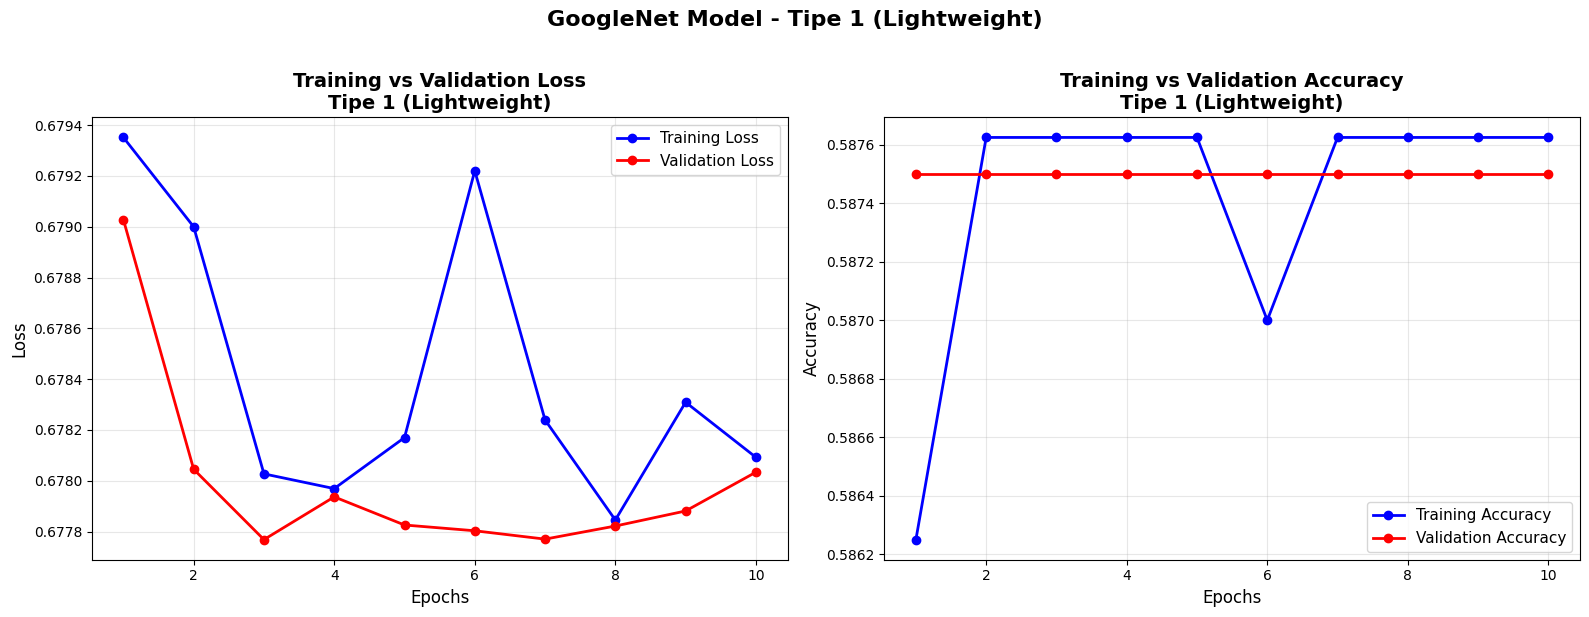


📊 SUMMARY HASIL TRAINING - GOOGLENET TIPE 1
Epochs: 10 | Batch Size: 32 | LR: 0.001
------------------------------------------------------------
Final Training Loss      : 0.6781
Final Training Accuracy  : 0.5876 (58.76%)
Final Validation Loss    : 0.6780
Final Validation Accuracy: 0.5875 (58.75%)
Training Duration        : 115.66s (1.93 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [14]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type1 = history_type1.history['loss']
val_loss_values_type1 = history_type1.history['val_loss']
accuracy_values_type1 = history_type1.history['accuracy']
val_accuracy_values_type1 = history_type1.history['val_accuracy']

epochs_range = range(1, len(loss_values_type1) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type1, 'bo-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type1, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 1 (Lightweight)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type1, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type1, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 1 (Lightweight)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('GoogleNet Model - Tipe 1 (Lightweight)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - GOOGLENET TIPE 1")
print("="*60)
print(f"Epochs: {epochs_type1} | Batch Size: {batch_size_type1} | LR: {learning_rate_type1}")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type1[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type1[-1]:.4f} ({accuracy_values_type1[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type1[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type1[-1]:.4f} ({val_accuracy_values_type1[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type1:.2f}s ({training_duration_type1/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type1[-1] - val_accuracy_values_type1[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
    print("   Saran: Tambah dropout, data augmentation, atau kurangi epochs")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
    print("   Validation accuracy lebih tinggi dari training accuracy")
    print("   Saran: Tambah epochs atau tuning learning rate")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

In [15]:
print("="*60)
print("📈 EVALUASI MODEL GOOGLENET - TIPE 1")
print("="*60)

# Evaluate pada validation set
loss_type1, accuracy_type1 = model_type1.evaluate(val_images, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - GOOGLENET TIPE 1")
print("="*60)
print(f"Validation Loss    : {loss_type1:.4f}")
print(f"Validation Accuracy: {accuracy_type1:.4f} ({accuracy_type1*100:.2f}%)")
print("="*60)

# Interpretasi hasil
if accuracy_type1 > 0.85:
    print("\n✅ Model GoogleNet Tipe 1 memiliki performa BAIK!")
    print("   Akurasi >85% menunjukkan model dapat mengklasifikasi dengan baik.")
elif accuracy_type1 > 0.75:
    print("\n⚠️  Model GoogleNet Tipe 1 cukup baik, masih bisa ditingkatkan.")
    print("   Coba eksperimen dengan hyperparameter tuning atau data augmentation.")
else:
    print("\n❌ Model GoogleNet Tipe 1 perlu perbaikan signifikan.")
    print("   Kemungkinan underfitting atau perlu training lebih lama.")
    print("   Saran: Tambah epochs, tuning learning rate, atau coba arsitektur lain.")

📈 EVALUASI MODEL GOOGLENET - TIPE 1
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5736 - loss: 0.6823

📊 HASIL EVALUASI FINAL - GOOGLENET TIPE 1
Validation Loss    : 0.6780
Validation Accuracy: 0.5875 (58.75%)

❌ Model GoogleNet Tipe 1 perlu perbaikan signifikan.
   Kemungkinan underfitting atau perlu training lebih lama.
   Saran: Tambah epochs, tuning learning rate, atau coba arsitektur lain.


## GoogleNet - V2

### Build Model GoogleNet

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definisi ukuran input (Height, Width, Channels)
input_shape = (64, 64, 3)

print("="*60)
print("🟢 GOOGLENET TIPE 2 - HEAVY (Deep & Comprehensive)")
print("="*60)

# === DEFINISI INCEPTION MODULE ===
# (Sama dengan Tipe 1, digunakan ulang)
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3,
                     filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """
    Inception Module: Inti dari arsitektur GoogleNet

    Berbeda dengan VGG yang hanya pakai kernel 3x3 bertumpuk,
    Inception module menggabungkan beberapa ukuran kernel (1x1, 3x3, 5x5)
    secara paralel untuk menangkap fitur di berbagai skala.

    Keuntungan:
    - Parameter lebih sedikit dari VGG
    - Lebih efisien secara komputasi
    - Bisa tangkap fitur multi-scale sekaligus
    """
    # Path 1: Konvolusi 1x1
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # Path 2: Konvolusi 1x1 → 3x3
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    # Path 3: Konvolusi 1x1 → 5x5
    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # Path 4: MaxPooling → 1x1
    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Gabungkan semua path
    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return output

# === BUILD GOOGLENET MODEL ===
print("Membangun arsitektur GoogleNet...")

input_layer = layers.Input(shape=input_shape)

# === LAYER AWAL: Konvolusi dan Pooling ===
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# === INCEPTION MODULES ===
# Inception Block 3
x = inception_module(x, 64, 96, 128, 16, 32, 32)   # 3a
x = inception_module(x, 128, 128, 192, 32, 96, 64) # 3b
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception Block 4
x = inception_module(x, 192, 96, 208, 16, 48, 64)   # 4a
x = inception_module(x, 160, 112, 224, 24, 64, 64)  # 4b
x = inception_module(x, 128, 128, 256, 24, 64, 64)  # 4c
x = inception_module(x, 112, 144, 288, 32, 64, 64)  # 4d
x = inception_module(x, 256, 160, 320, 32, 128, 128) # 4e
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception Block 5
x = inception_module(x, 256, 160, 320, 32, 128, 128) # 5a
x = inception_module(x, 384, 192, 384, 48, 128, 128) # 5b

# === LAYER AKHIR ===
# GlobalAveragePooling: lebih efisien dari Flatten
x = layers.GlobalAveragePooling2D()(x)

# Dropout: Cegah overfitting
x = layers.Dropout(0.4)(x)

# Output layer: Binary classification
output_layer = layers.Dense(1, activation='sigmoid', name='main_output')(x)

# Buat model
model_type2 = models.Model(inputs=input_layer, outputs=output_layer)

# Tampilkan arsitektur model
print("\n=== Arsitektur Model GoogleNet Tipe 2 ===")
model_type2.summary()
print(f"\nTotal parameter: {model_type2.count_params():,}")
print("="*60)

print("\n📌 Note: Arsitektur SAMA dengan Tipe 1, perbedaan di hyperparameter training")

🟢 GOOGLENET TIPE 2 - HEAVY (Deep & Comprehensive)
Membangun arsitektur GoogleNet...

=== Arsitektur Model GoogleNet Tipe 2 ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 32, 32,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 16, 16,    │          0 │ conv2d_57[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 16, 16,    │      4,160 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 16, 16,    │    110,784 │ conv2d_58[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 8, 8, 192) │          0 │ conv2d_59[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 8, 8, 96)  │     18,528 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 8, 8, 16)  │      3,088 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 8, 8, 192) │          0 │ max_pooling2d_14… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 8, 8, 64)  │     12,352 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 8, 8, 128) │    110,720 │ conv2d_61[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 8, 8, 32)  │     12,832 │ conv2d_63[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 8, 8, 32)  │      6,176 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 8, 8, 256) │          0 │ conv2d_60[0][0],  │
│ (Concatenate)       │                   │            │ conv2d_62[0][0],  │
│                     │                   │            │ conv2d_64[0][0],  │
│                     │                   │            │ conv2d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 8, 8, 128) │     32,896 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 8, 8, 32)  │      8,224 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 8, 8, 256) │          0 │ concatenate_9[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 8, 8, 128) │     32,896 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 8, 8, 192) │    221,376 │ conv2d_67[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,974,577 (22.79 MB)

 Trainable params: 5,974,577 (22.79 MB)

 Non-trainable params: 0 (0.00 B)


Total parameter: 5,974,577

📌 Note: Arsitektur SAMA dengan Tipe 1, perbedaan di hyperparameter training


### Compile Model

In [17]:
from tensorflow.keras.optimizers import Adam

# === KONFIGURASI TIPE 2 - HEAVY ===
config_name = "Heavy - Deep & Comprehensive"
learning_rate_type2 = 0.0001  # Learning rate lebih kecil (10x dari Tipe 1)

print("="*60)
print("🟢 COMPILE MODEL - TIPE 2 (HEAVY)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print(f"Learning Rate: {learning_rate_type2}")
print(f"Optimizer: Adam")
print(f"Loss Function: Binary Crossentropy")
print("="*60)

print("\n📌 REASONING TIPE 2 (Heavy):")
print("-"*60)
print("""
- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Learning rate kecil untuk fine-tuning lebih halus
  → Mencegah overshoot saat mendekati konvergensi
  → Membantu model tidak "melompat" keluar dari local minima
  → Trade-off: Butuh epochs lebih banyak untuk konvergen

- Optimizer: Adam
  → Tetap pakai Adam karena terbukti robust
  → Adaptive learning rate membantu dengan LR kecil
  → Efisien untuk arsitektur kompleks seperti GoogleNet

- Loss: Binary Crossentropy
  → Sama dengan Tipe 1, standard untuk binary classification

- GoogleNet Complexity:
  → Inception module butuh tuning lebih halus
  → Multi-path architecture sensitif terhadap learning rate
  → LR kecil membantu semua path konvergen seimbang

✅ TUJUAN: Maximum performance dengan training lebih dalam
""")
print("="*60)

# Compile model
model_type2.compile(
    optimizer=Adam(learning_rate=learning_rate_type2),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model GoogleNet Tipe 2 berhasil dikompilasi!")

🟢 COMPILE MODEL - TIPE 2 (HEAVY)
Konfigurasi: Heavy - Deep & Comprehensive
Learning Rate: 0.0001
Optimizer: Adam
Loss Function: Binary Crossentropy

📌 REASONING TIPE 2 (Heavy):
------------------------------------------------------------

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Learning rate kecil untuk fine-tuning lebih halus
  → Mencegah overshoot saat mendekati konvergensi
  → Membantu model tidak "melompat" keluar dari local minima
  → Trade-off: Butuh epochs lebih banyak untuk konvergen

- Optimizer: Adam
  → Tetap pakai Adam karena terbukti robust
  → Adaptive learning rate membantu dengan LR kecil
  → Efisien untuk arsitektur kompleks seperti GoogleNet

- Loss: Binary Crossentropy
  → Sama dengan Tipe 1, standard untuk binary classification

- GoogleNet Complexity:
  → Inception module butuh tuning lebih halus
  → Multi-path architecture sensitif terhadap learning rate
  → LR kecil membantu semua path konvergen seimbang

✅ TUJUAN: Maximum performance dengan tra

### Train Model

In [18]:
import time

# === KONFIGURASI TRAINING TIPE 2 ===
epochs_type2 = 20  # 2x lebih banyak dari Tipe 1
batch_size_type2 = 64  # 2x lebih besar dari Tipe 1

print("="*60)
print("🚀 TRAINING MODEL GOOGLENET - TIPE 2")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type2}")
print(f"Batch Size: {batch_size_type2}")
print(f"Learning Rate: {learning_rate_type2}")
print("-"*60)
print(f"Total training samples: {len(train_images):,}")
print(f"Total validation samples: {len(val_images):,}")
print(f"Steps per epoch: {len(train_images) // batch_size_type2}")
print(f"Total steps: {(len(train_images) // batch_size_type2) * epochs_type2}")
print("="*60)

print("\n📌 REASONING HYPERPARAMETER TIPE 2:")
print("-"*60)
print("""
- Epochs: 20 (2x dari Tipe 1)
  → Lebih banyak iterasi untuk model belajar pattern kompleks
  → GoogleNet dengan Inception module butuh waktu lebih untuk konvergen
  → Memberi kesempatan semua path (1x1, 3x3, 5x5) belajar optimal

- Batch Size: 64 (2x dari Tipe 1)
  → Batch lebih besar = gradient update lebih stabil
  → Mengurangi noise dalam training process
  → Lebih efficient untuk GPU utilization
  → Trade-off: Butuh memory lebih besar

- Learning Rate: 0.0001 (kecil)
  → Kombinasi LR kecil + batch besar = konvergensi smooth
  → Cocok untuk fine-tuning arsitektur kompleks GoogleNet
  → Semua Inception path bisa konvergen seimbang

- GoogleNet vs VGG (Tipe 2):
  → GoogleNet: Lebih kompleks, multi-path architecture
  → GoogleNet: Butuh tuning lebih careful untuk optimal
  → VGG: Monoton stack 3x3, lebih straightforward
  → GoogleNet: Potensial akurasi lebih tinggi jika tuned well

✅ COCOK UNTUK: Production model, maximum accuracy
""")
print("="*60)

# Catat waktu mulai training
start_time = time.time()

# Train model
history_type2 = model_type2.fit(
    train_images,
    train_labels,
    epochs=epochs_type2,
    batch_size=batch_size_type2,
    validation_data=(val_images, val_labels),
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_type2 = end_time - start_time

print("\n" + "="*60)
print("✅ TRAINING GOOGLENET TIPE 2 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_type2:.2f} detik ({training_duration_type2/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_type2.history['accuracy'][-1]:.4f} ({history_type2.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_type2.history['val_accuracy'][-1]:.4f} ({history_type2.history['val_accuracy'][-1]*100:.2f}%)")
print("="*60)

🚀 TRAINING MODEL GOOGLENET - TIPE 2
Konfigurasi: Heavy - Deep & Comprehensive
------------------------------------------------------------
Epochs: 20
Batch Size: 64
Learning Rate: 0.0001
------------------------------------------------------------
Total training samples: 8,000
Total validation samples: 2,000
Steps per epoch: 125
Total steps: 2500

📌 REASONING HYPERPARAMETER TIPE 2:
------------------------------------------------------------

- Epochs: 20 (2x dari Tipe 1)
  → Lebih banyak iterasi untuk model belajar pattern kompleks
  → GoogleNet dengan Inception module butuh waktu lebih untuk konvergen
  → Memberi kesempatan semua path (1x1, 3x3, 5x5) belajar optimal

- Batch Size: 64 (2x dari Tipe 1)
  → Batch lebih besar = gradient update lebih stabil
  → Mengurangi noise dalam training process
  → Lebih efficient untuk GPU utilization
  → Trade-off: Butuh memory lebih besar

- Learning Rate: 0.0001 (kecil)
  → Kombinasi LR kecil + batch besar = konvergensi smooth
  → Cocok untuk fi

### Plot Training History

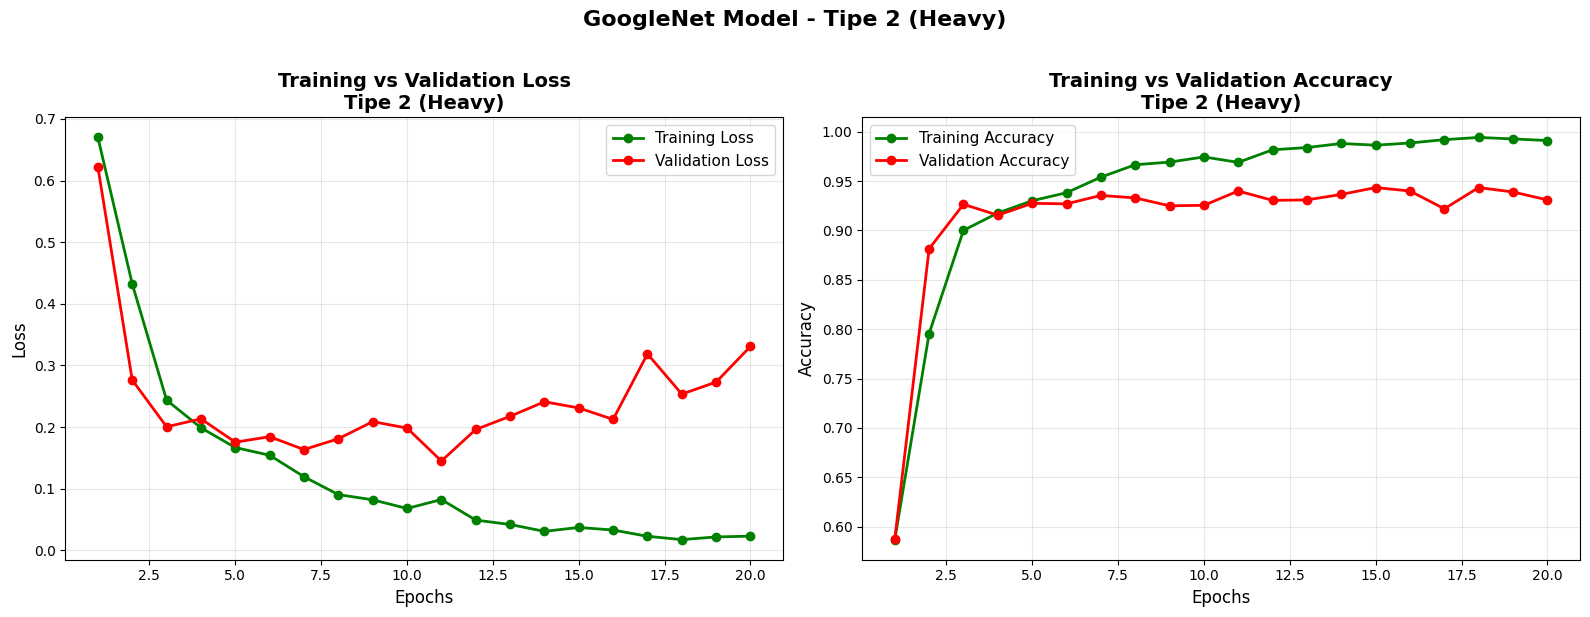


📊 SUMMARY HASIL TRAINING - GOOGLENET TIPE 2
Epochs: 20 | Batch Size: 64 | LR: 0.0001
------------------------------------------------------------
Final Training Loss      : 0.0229
Final Training Accuracy  : 0.9911 (99.11%)
Final Validation Loss    : 0.3309
Final Validation Accuracy: 0.9310 (93.10%)
Training Duration        : 134.41s (2.24 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [20]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type2 = history_type2.history['loss']
val_loss_values_type2 = history_type2.history['val_loss']
accuracy_values_type2 = history_type2.history['accuracy']
val_accuracy_values_type2 = history_type2.history['val_accuracy']

epochs_range = range(1, len(loss_values_type2) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type2, 'go-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type2, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 2 (Heavy)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type2, 'go-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type2, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 2 (Heavy)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('GoogleNet Model - Tipe 2 (Heavy)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - GOOGLENET TIPE 2")
print("="*60)
print(f"Epochs: {epochs_type2} | Batch Size: {batch_size_type2} | LR: {learning_rate_type2}")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type2[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type2[-1]:.4f} ({accuracy_values_type2[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type2[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type2[-1]:.4f} ({val_accuracy_values_type2[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type2:.2f}s ({training_duration_type2/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type2[-1] - val_accuracy_values_type2[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
    print("   Saran: Tambah dropout, data augmentation, atau kurangi epochs")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
    print("   Saran: Tambah epochs atau tuning learning rate")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

In [21]:
print("="*60)
print("📈 EVALUASI MODEL GOOGLENET - TIPE 2")
print("="*60)

# Evaluate pada validation set
loss_type2, accuracy_type2 = model_type2.evaluate(val_images, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - GOOGLENET TIPE 2")
print("="*60)
print(f"Validation Loss    : {loss_type2:.4f}")
print(f"Validation Accuracy: {accuracy_type2:.4f} ({accuracy_type2*100:.2f}%)")
print("="*60)

# Interpretasi hasil
if accuracy_type2 > 0.85:
    print("\n✅ Model GoogleNet Tipe 2 memiliki performa BAIK!")
elif accuracy_type2 > 0.75:
    print("\n⚠️  Model GoogleNet Tipe 2 cukup baik, masih bisa ditingkatkan.")
else:
    print("\n❌ Model GoogleNet Tipe 2 perlu perbaikan.")

📈 EVALUASI MODEL GOOGLENET - TIPE 2
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9281 - loss: 0.3533

📊 HASIL EVALUASI FINAL - GOOGLENET TIPE 2
Validation Loss    : 0.3309
Validation Accuracy: 0.9310 (93.10%)

✅ Model GoogleNet Tipe 2 memiliki performa BAIK!


## Test (V1 + V2)

🔵🟢 TEST PREDIKSI - GOOGLENET TIPE 1 & TIPE 2
Upload gambar sekali, test di kedua model sekaligus
------------------------------------------------------------


Saving LUCINTA.webp to LUCINTA.webp

📷 Memproses gambar: "LUCINTA.webp"
Ukuran file: 6,030 bytes

📊 HASIL PREDIKSI UNTUK: LUCINTA.webp
🔵 GOOGLENET TIPE 1 (Lightweight):
   Prediksi: Female
   Prob Male: 0.4241 (42.41%)
   Confidence: 0.5759 (57.59%)

🟢 GOOGLENET TIPE 2 (Heavy):
   Prediksi: Female
   Prob Male: 0.0183 (1.83%)
   Confidence: 0.9817 (98.17%)

✅ KEDUA MODEL SEPAKAT: Female


/tmp/ipython-input-1890946358.py:135: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1890946358.py:135: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


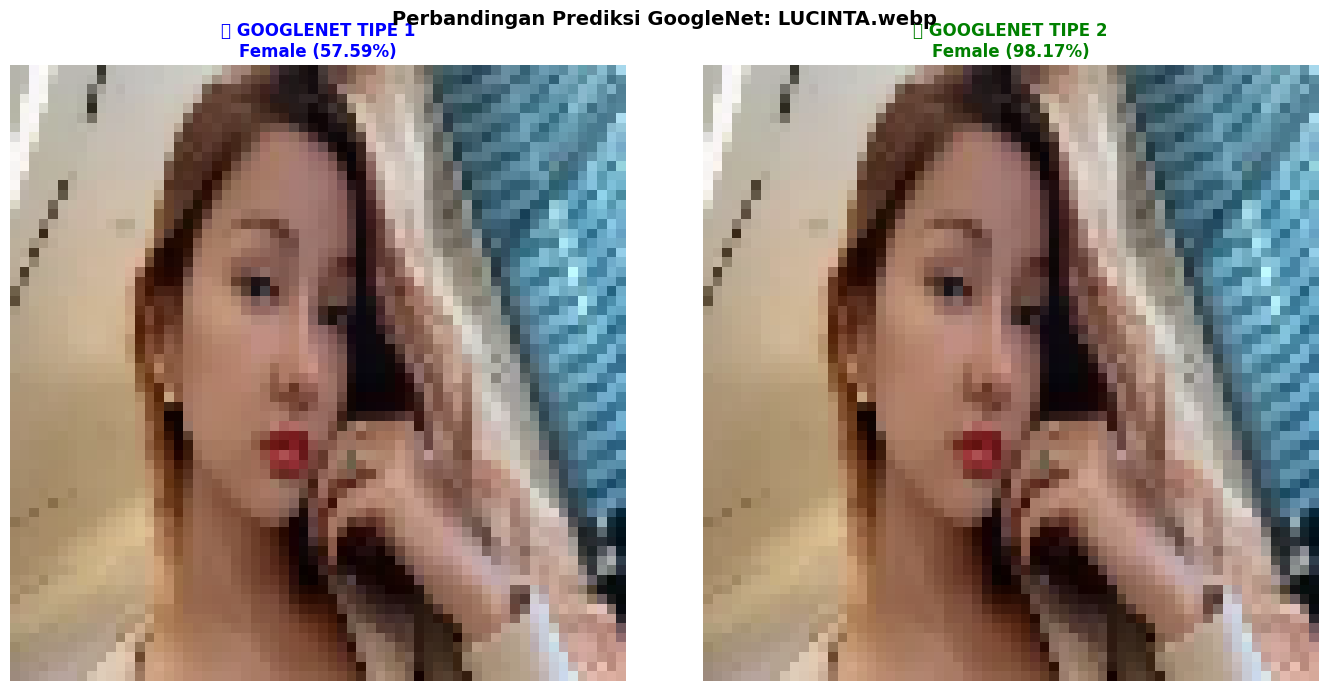


✅ Prediksi kedua model selesai!


In [22]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("🔵🟢 TEST PREDIKSI - GOOGLENET TIPE 1 & TIPE 2")
print("="*60)
print("Upload gambar sekali, test di kedua model sekaligus")
print("-"*60)

# Upload gambar dari komputer lokal
uploaded = files.upload()

# Simpan hasil prediksi untuk perbandingan
predictions_comparison = []

# Proses setiap gambar yang diupload
for fn in uploaded.keys():
    print(f'\n{"="*60}')
    print(f'📷 Memproses gambar: "{fn}"')
    print(f'Ukuran file: {len(uploaded[fn]):,} bytes')
    print(f'{"="*60}')

    # Baca gambar
    image_path = fn
    img = cv2.imread(image_path)

    if img is None:
        print(f"❌ Error: Tidak dapat membaca gambar {image_path}")
        continue

    # === PREPROCESSING (SAMA DENGAN TRAINING) ===

    # 1. Resize ke ukuran input model (64x64)
    target_size = (64, 64)
    img_resized = cv2.resize(img, target_size)

    # 2. Konversi BGR (OpenCV) ke RGB (sesuai training)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # 3. Normalisasi: ubah range piksel dari [0, 255] ke [0, 1]
    img_normalized = img_rgb.astype('float32') / 255.0

    # 4. Tambah dimensi batch: (64, 64, 3) -> (1, 64, 64, 3)
    img_input = np.expand_dims(img_normalized, axis=0)

    # === PREDIKSI DENGAN KEDUA MODEL ===
    results = {}

    # Prediksi Model Tipe 1
    if 'model_type1' in globals():
        pred1 = model_type1.predict(img_input, verbose=0)
        prob_male_1 = pred1[0][0]
        class_1 = "Male" if prob_male_1 > 0.5 else "Female"
        conf_1 = prob_male_1 if prob_male_1 > 0.5 else (1 - prob_male_1)
        results['type1'] = {
            'prob_male': prob_male_1,
            'class': class_1,
            'confidence': conf_1
        }
    else:
        print("⚠️  Model Tipe 1 tidak ditemukan, skip prediksi Tipe 1")

    # Prediksi Model Tipe 2
    if 'model_type2' in globals():
        pred2 = model_type2.predict(img_input, verbose=0)
        prob_male_2 = pred2[0][0]
        class_2 = "Male" if prob_male_2 > 0.5 else "Female"
        conf_2 = prob_male_2 if prob_male_2 > 0.5 else (1 - prob_male_2)
        results['type2'] = {
            'prob_male': prob_male_2,
            'class': class_2,
            'confidence': conf_2
        }
    else:
        print("⚠️  Model Tipe 2 tidak ditemukan, skip prediksi Tipe 2")

    # Simpan hasil untuk tabel perbandingan
    if 'type1' in results and 'type2' in results:
        predictions_comparison.append({
            'filename': fn,
            'type1_prob_male': results['type1']['prob_male'],
            'type1_class': results['type1']['class'],
            'type1_conf': results['type1']['confidence'],
            'type2_prob_male': results['type2']['prob_male'],
            'type2_class': results['type2']['class'],
            'type2_conf': results['type2']['confidence']
        })

    # === TAMPILKAN HASIL SIDE-BY-SIDE ===
    print(f"\n📊 HASIL PREDIKSI UNTUK: {fn}")
    print(f"="*60)

    if 'type1' in results:
        print(f"🔵 GOOGLENET TIPE 1 (Lightweight):")
        print(f"   Prediksi: {results['type1']['class']}")
        print(f"   Prob Male: {results['type1']['prob_male']:.4f} ({results['type1']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type1']['confidence']:.4f} ({results['type1']['confidence']*100:.2f}%)")

    if 'type2' in results:
        print(f"\n🟢 GOOGLENET TIPE 2 (Heavy):")
        print(f"   Prediksi: {results['type2']['class']}")
        print(f"   Prob Male: {results['type2']['prob_male']:.4f} ({results['type2']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type2']['confidence']:.4f} ({results['type2']['confidence']*100:.2f}%)")

    # Cek apakah prediksi sama atau beda
    if 'type1' in results and 'type2' in results:
        if results['type1']['class'] == results['type2']['class']:
            print(f"\n✅ KEDUA MODEL SEPAKAT: {results['type1']['class']}")
        else:
            print(f"\n⚠️  PREDIKSI BERBEDA!")
            print(f"   Tipe 1: {results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)")
            print(f"   Tipe 2: {results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)")

    print(f"="*60)

    # === VISUALISASI SIDE-BY-SIDE ===
    if 'type1' in results and 'type2' in results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Model Tipe 1
        axes[0].imshow(img_rgb)
        axes[0].set_title(f"🔵 GOOGLENET TIPE 1\n{results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='blue')
        axes[0].axis('off')

        # Model Tipe 2
        axes[1].imshow(img_rgb)
        axes[1].set_title(f"🟢 GOOGLENET TIPE 2\n{results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='green')
        axes[1].axis('off')

        plt.suptitle(f"Perbandingan Prediksi GoogleNet: {fn}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

print("\n" + "="*60)
print("✅ Prediksi kedua model selesai!")
print("="*60)

# ResNet

## Setup Kaggle di Colab

In [1]:
# Install Kaggle
!pip install kaggle -q
import os
import sys

# Buat direktori .kaggle jika belum ada
!mkdir -p ~/.kaggle

# Cek apakah file kaggle.json sudah diupload
if os.path.exists('/content/kaggle.json'):
    # Pindahkan kaggle.json ke direktori .kaggle
    !mv /content/kaggle.json ~/.kaggle/
    # Set permission file agar secure
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json berhasil dikonfigurasi.")
else:
    print("kaggle.json tidak ditemukan di /content/. Silakan upload file kaggle.json terlebih dahulu.")

kaggle.json berhasil dikonfigurasi.


## Download Dataset dari Kaggle

In [2]:
# Download dataset CelebA 64x64 dari Kaggle
!kaggle datasets download -d therealcyberlord/50k-celeba-dataset-64x64

Dataset URL: https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64
License(s): unknown
 68% 53.0M/78.1M [00:00<00:00, 556MB/s]
100% 78.1M/78.1M [00:00<00:00, 592MB/s]


## Extract Dataset

In [3]:
import zipfile
import os

# Path file zip yang telah didownload
zip_file_path = '/content/50k-celeba-dataset-64x64.zip'

# Direktori tujuan ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'

# Buat folder ekstraksi jika belum ada
os.makedirs(extracted_path, exist_ok=True)

# Ekstrak file zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Dataset berhasil diekstrak.")
except FileNotFoundError:
    print(f"Error: File {zip_file_path} tidak ditemukan. Pastikan download berhasil.")
except zipfile.BadZipFile:
    print(f"Error: File {zip_file_path} bukan zip yang valid. Download mungkin corrupt.")
except Exception as e:
    print(f"Error saat ekstraksi: {e}")

Dataset berhasil diekstrak.


## Cek Isi Folder

In [4]:
import os

# Tampilkan isi direktori hasil ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'
print("Isi folder ekstraksi:")
print(os.listdir(extracted_path))

Isi folder ekstraksi:
['50k']


## Download Attribute File (Label)


In [5]:
# Download file atribut dari GitHub (alternatif jika gagal)
# Opsional: Bisa juga download manual dari Google Drive
# Link Google Drive: https://drive.google.com/drive/folders/1AA21MR8GeQdnOVgmNcbxCrbAjL1udj0l

import requests
import os

# URL file atribut CelebA
attribute_file_url = "https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt"
attribute_file_path = "/content/list_attr_celeba.txt"

print(f"Mencoba download file atribut dari: {attribute_file_url}")

try:
    response = requests.get(attribute_file_url, stream=True)
    response.raise_for_status()  # Raise error jika status 4xx atau 5xx

    with open(attribute_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"File atribut berhasil didownload ke: {attribute_file_path}")

except requests.exceptions.RequestException as e:
    print(f"Error saat download file atribut: {e}")
    print("Tidak dapat mendownload file dari URL yang diberikan.")
    print("Silakan download manual dari Google Drive dan upload ke Colab.")
except Exception as e:
    print(f"Error saat memproses file atribut: {e}")

Mencoba download file atribut dari: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Error saat download file atribut: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Tidak dapat mendownload file dari URL yang diberikan.
Silakan download manual dari Google Drive dan upload ke Colab.


## Import Library

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import os

print("✅ Library berhasil diimport")
print(f"TensorFlow version: {tf.__version__}")

✅ Library berhasil diimport
TensorFlow version: 2.19.0


## Load Dataset & Preprocessing

In [7]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

# Path direktori gambar dan file atribut
img_dir = "/content/celeba_dataset_kaggle/50k"
attr_path = "/content/list_attr_celeba.txt"

print("="*60)
print("🔵 RESNET TIPE 1 - LIGHTWEIGHT (Transfer Learning)")
print("="*60)
print("Memulai loading dataset...")

# === VALIDASI DIREKTORI GAMBAR ===
if not os.path.exists(img_dir):
    print(f"❌ Error: Direktori gambar tidak ditemukan di {img_dir}")
    images, labels = np.array([]), np.array([])
else:
    # List semua file gambar
    image_files_in_dir = [f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')]

    if not image_files_in_dir:
        print(f"❌ Error: Tidak ada file gambar di {img_dir}")
        images, labels = np.array([]), np.array([])
    else:
        print(f"✅ Ditemukan {len(image_files_in_dir)} file gambar di {img_dir}")

        # === LOAD FILE ATRIBUT ===
        try:
            # Load attribute file (skip baris pertama = jumlah total, gunakan kolom pertama sebagai index)
            attributes = pd.read_csv(attr_path, skiprows=1, sep=r'\s+', index_col=0)
            print(f"✅ File atribut berhasil diload dari {attr_path}")

            # === SAMPLE DATA ===
            # Untuk ResNet, gunakan sample lebih kecil karena model lebih berat
            sample_size = 2000  # Lebih ringan untuk Colab Free

            # Filter: hanya ambil yang ada gambarnya
            available_image_ids = [os.path.basename(f) for f in image_files_in_dir]
            attributes_available = attributes[attributes.index.isin(available_image_ids)]

            if len(attributes_available) < sample_size:
                print(f"⚠️  Warning: Hanya {len(attributes_available)} gambar dengan atribut tersedia.")
                print(f"   Loading semua data yang tersedia.")
                sample_data = attributes_available
            else:
                sample_data = attributes_available.sample(sample_size, random_state=42)

            print(f"\n📦 Sample data: {len(sample_data)} gambar")

            # === LOAD & PREPROCESS GAMBAR ===
            images = []
            labels = []

            print("\n🔄 Loading dan preprocessing gambar...")
            for idx, (filename, row) in enumerate(sample_data.iterrows()):
                img_path = os.path.join(img_dir, filename)
                img = cv2.imread(img_path)

                if img is not None:
                    # Resize ke 128x128 (input ResNet50)
                    # ResNet biasanya pakai 224x224, tapi 128x128 cukup untuk Colab Free
                    img = cv2.resize(img, (128, 128))

                    # Konversi BGR ke RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Normalisasi ke [0, 1]
                    img = img / 255.0

                    images.append(img)
                    labels.append(1 if row['Male'] == 1 else 0)
                else:
                    print(f"⚠️  Warning: Tidak dapat load {img_path}")

                # Progress indicator setiap 200 gambar
                if (idx + 1) % 200 == 0:
                    print(f"   Progress: {idx + 1}/{len(sample_data)} gambar")

            # Konversi ke numpy array
            images = np.array(images)
            labels = np.array(labels)

            print(f"\n{'='*60}")
            print("✅ BERHASIL LOAD DATA")
            print(f"{'='*60}")
            print(f"Total gambar: {len(images)}")
            print(f"Shape gambar: {images.shape}")
            print(f"Shape label: {labels.shape}")
            print(f"Range nilai piksel: [{images.min():.2f}, {images.max():.2f}]")
            print(f"Distribusi label: Female={int((labels==0).sum())}, Male={int((labels==1).sum())}")
            print(f"{'='*60}")

        except FileNotFoundError:
            print(f"❌ Error: File atribut tidak ditemukan di {attr_path}")
            print("   Pastikan file sudah diupload/extract dengan benar.")
            images, labels = np.array([]), np.array([])
        except KeyError:
            print(f"❌ Error: Kolom 'Male' tidak ditemukan di file atribut.")
            images, labels = np.array([]), np.array([])
        except Exception as e:
            print(f"❌ Error tidak terduga saat loading data: {e}")
            images, labels = np.array([]), np.array([])

# === SPLIT DATA ===
if len(images) > 0:
    print("\n🔄 Melakukan split data...")

    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels,
        test_size=0.2,       # 20% untuk validation
        random_state=42,     # Reproducibility
        stratify=labels      # Jaga keseimbangan kelas
    )

    print(f"\n{'='*60}")
    print("=== Hasil Split Data ===")
    print(f"{'='*60}")
    print(f"Training set   : {train_images.shape}")
    print(f"Validation set : {val_images.shape}")
    print(f"Training labels: {train_labels.shape}")
    print(f"Validation labels: {val_labels.shape}")
    print(f"\nDistribusi Training   - Female: {(train_labels==0).sum()}, Male: {(train_labels==1).sum()}")
    print(f"Distribusi Validation - Female: {(val_labels==0).sum()}, Male: {(val_labels==1).sum()}")
    print(f"{'='*60}")
    print("\n✅ Data ready untuk training!")

else:
    print("\n❌ Data loading gagal. Tidak dapat melanjutkan.")
    train_images, val_images, train_labels, val_labels = None, None, None, None

🔵 RESNET TIPE 1 - LIGHTWEIGHT (Transfer Learning)
Memulai loading dataset...
✅ Ditemukan 50000 file gambar di /content/celeba_dataset_kaggle/50k
✅ File atribut berhasil diload dari /content/list_attr_celeba.txt

📦 Sample data: 2000 gambar

🔄 Loading dan preprocessing gambar...
   Progress: 200/2000 gambar
   Progress: 400/2000 gambar
   Progress: 600/2000 gambar
   Progress: 800/2000 gambar
   Progress: 1000/2000 gambar
   Progress: 1200/2000 gambar
   Progress: 1400/2000 gambar
   Progress: 1600/2000 gambar
   Progress: 1800/2000 gambar
   Progress: 2000/2000 gambar

✅ BERHASIL LOAD DATA
Total gambar: 2000
Shape gambar: (2000, 128, 128, 3)
Shape label: (2000,)
Range nilai piksel: [0.00, 1.00]
Distribusi label: Female=1164, Male=836

🔄 Melakukan split data...

=== Hasil Split Data ===
Training set   : (1600, 128, 128, 3)
Validation set : (400, 128, 128, 3)
Training labels: (1600,)
Validation labels: (400,)

Distribusi Training   - Female: 931, Male: 669
Distribusi Validation - Female: 

## ResNet - V1

### Build Model ResNet

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def build_resnet_light(learning_rate=0.001, dropout_rate=0.2):
    """
    Membangun ResNet50 dengan Transfer Learning untuk binary classification

    Args:
        learning_rate: Learning rate untuk optimizer
        dropout_rate: Dropout rate untuk regularisasi

    Returns:
        model: ResNet50 model yang sudah dikompilasi
    """
    print("Membangun ResNet50 dengan Transfer Learning...")

    # === LOAD PRETRAINED RESNET50 ===
    # weights='imagenet': Gunakan weights dari ImageNet (pretrained)
    # include_top=False: Buang layer klasifikasi terakhir (1000 kelas ImageNet)
    # input_shape: Ukuran input 128x128 RGB
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3)
    )

    # === FREEZE BASE MODEL ===
    # Transfer Learning: Freeze semua layer ResNet50
    # Hanya train layer custom yang kita tambahkan
    # Ini membuat training lebih cepat dan butuh data lebih sedikit
    base_model.trainable = False

    print(f"ResNet50 base model loaded (frozen)")
    print(f"Total layers di base model: {len(base_model.layers)}")

    # === CUSTOM LAYERS ===
    # GlobalAveragePooling2D: Mengambil rata-rata nilai tiap feature map
    # Alternatif dari Flatten, lebih efisien dan reduce overfitting
    x = GlobalAveragePooling2D()(base_model.output)

    # Dropout: Regularisasi untuk cegah overfitting
    x = Dropout(dropout_rate)(x)

    # Output layer: Binary classification (Male/Female)
    # Sigmoid activation untuk output probabilitas 0-1
    output = Dense(1, activation='sigmoid')(x)

    # === BUILD MODEL ===
    model = Model(inputs=base_model.input, outputs=output)

    # === COMPILE MODEL ===
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("="*60)
print("🔵 BUILD MODEL RESNET - TIPE 1 (LIGHTWEIGHT)")
print("="*60)

# Build model dengan hyperparameter Tipe 1
model_type1 = build_resnet_light(
    learning_rate=0.001,  # Learning rate standard
    dropout_rate=0.2      # Dropout rate rendah
)

print("\n=== Arsitektur Model ResNet Tipe 1 ===")
model_type1.summary()

# Hitung total parameter
total_params = model_type1.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model_type1.trainable_weights])
frozen_params = total_params - trainable_params

print(f"\n{'='*60}")
print(f"Total parameters    : {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} (layer custom)")
print(f"Frozen parameters   : {frozen_params:,} (ResNet50 base)")
print(f"{'='*60}")

print("\n📌 Note: Karena Transfer Learning, hanya {:.2f}% parameter yang dilatih".format(
    (trainable_params / total_params) * 100
))

🔵 BUILD MODEL RESNET - TIPE 1 (LIGHTWEIGHT)
Membangun ResNet50 dengan Transfer Learning...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 base model loaded (frozen)
Total layers di base model: 175

=== Arsitektur Model ResNet Tipe 1 ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Total parameters    : 23,589,761
Trainable parameters: 2,049 (layer custom)
Frozen parameters   : 23,587,712 (ResNet50 base)

📌 Note: Karena Transfer Learning, hanya 0.01% parameter yang dilatih


### Compile & Train Model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
import time

# === KONFIGURASI TRAINING TIPE 1 ===
config_name = "Lightweight - Transfer Learning"
batch_size_type1 = 8   # Batch kecil untuk Colab Free (ResNet berat)
epochs_type1 = 10

print("="*60)
print("🔵 TRAINING RESNET - TIPE 1 (LIGHTWEIGHT)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type1}")
print(f"Batch Size: {batch_size_type1}")
print(f"Learning Rate: 0.001")
print(f"Dropout Rate: 0.2")
print("-"*60)
print(f"Total training samples: {len(train_images):,}")
print(f"Total validation samples: {len(val_images):,}")
print(f"Steps per epoch: {len(train_images) // batch_size_type1}")
print("="*60)

print("\n📌 REASONING TIPE 1 (Lightweight - Transfer Learning):")
print("-"*60)
print("""
- Transfer Learning: Gunakan ResNet50 pretrained dari ImageNet
  → Freeze semua layer ResNet50 (tidak dilatih)
  → Hanya train layer custom (GlobalAvgPooling + Dense)
  → Butuh data lebih sedikit, training lebih cepat

- Batch Size: 8 (sangat kecil)
  → ResNet50 model berat (~25M parameters)
  → Batch kecil untuk Colab Free (RAM terbatas)
  → Trade-off: Training lebih lama per epoch

- Epochs: 10
  → Cukup untuk transfer learning (biasanya konvergen cepat)
  → EarlyStopping akan stop jika tidak ada improvement

- Dropout: 0.2 (rendah)
  → Pretrained model sudah robust
  → Dropout rendah cukup untuk regularisasi

- ResNet vs VGG vs GoogleNet:
  → ResNet: Skip connection, lebih dalam (50 layers), pretrained
  → VGG: Simple stack 3x3, train from scratch
  → GoogleNet: Inception module, train from scratch
  → ResNet: Paling efisien dengan transfer learning

✅ COCOK UNTUK: Quick deployment dengan pretrained model
""")
print("="*60)

# === EARLY STOPPING CALLBACK ===
# Stop training jika val_accuracy tidak meningkat selama 2 epoch
# Restore weights terbaik
early_stop = EarlyStopping(
    monitor='val_accuracy',     # Monitor validation accuracy
    patience=2,                 # Tunggu 2 epoch sebelum stop
    restore_best_weights=True,  # Restore weights terbaik
    verbose=1
)

# Catat waktu mulai training
start_time = time.time()

print("\n🚀 Training ResNet Tipe 1 dimulai...")
print("-"*60)

# Train model
history_type1 = model_type1.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=epochs_type1,
    batch_size=batch_size_type1,
    callbacks=[early_stop],
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_type1 = end_time - start_time

print("\n" + "="*60)
print("✅ TRAINING RESNET TIPE 1 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_type1:.2f} detik ({training_duration_type1/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_type1.history['accuracy'][-1]:.4f} ({history_type1.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_type1.history['val_accuracy'][-1]:.4f} ({history_type1.history['val_accuracy'][-1]*100:.2f}%)")
print(f"🛑 Early stopped at epoch: {len(history_type1.history['loss'])}/{epochs_type1}")
print("="*60)

🔵 TRAINING RESNET - TIPE 1 (LIGHTWEIGHT)
Konfigurasi: Lightweight - Transfer Learning
------------------------------------------------------------
Epochs: 10
Batch Size: 8
Learning Rate: 0.001
Dropout Rate: 0.2
------------------------------------------------------------
Total training samples: 1,600
Total validation samples: 400
Steps per epoch: 200

📌 REASONING TIPE 1 (Lightweight - Transfer Learning):
------------------------------------------------------------

- Transfer Learning: Gunakan ResNet50 pretrained dari ImageNet
  → Freeze semua layer ResNet50 (tidak dilatih)
  → Hanya train layer custom (GlobalAvgPooling + Dense)
  → Butuh data lebih sedikit, training lebih cepat

- Batch Size: 8 (sangat kecil)
  → ResNet50 model berat (~25M parameters)
  → Batch kecil untuk Colab Free (RAM terbatas)
  → Trade-off: Training lebih lama per epoch

- Epochs: 10
  → Cukup untuk transfer learning (biasanya konvergen cepat)
  → EarlyStopping akan stop jika tidak ada improvement

- Dropout: 0.

### Plot Training History

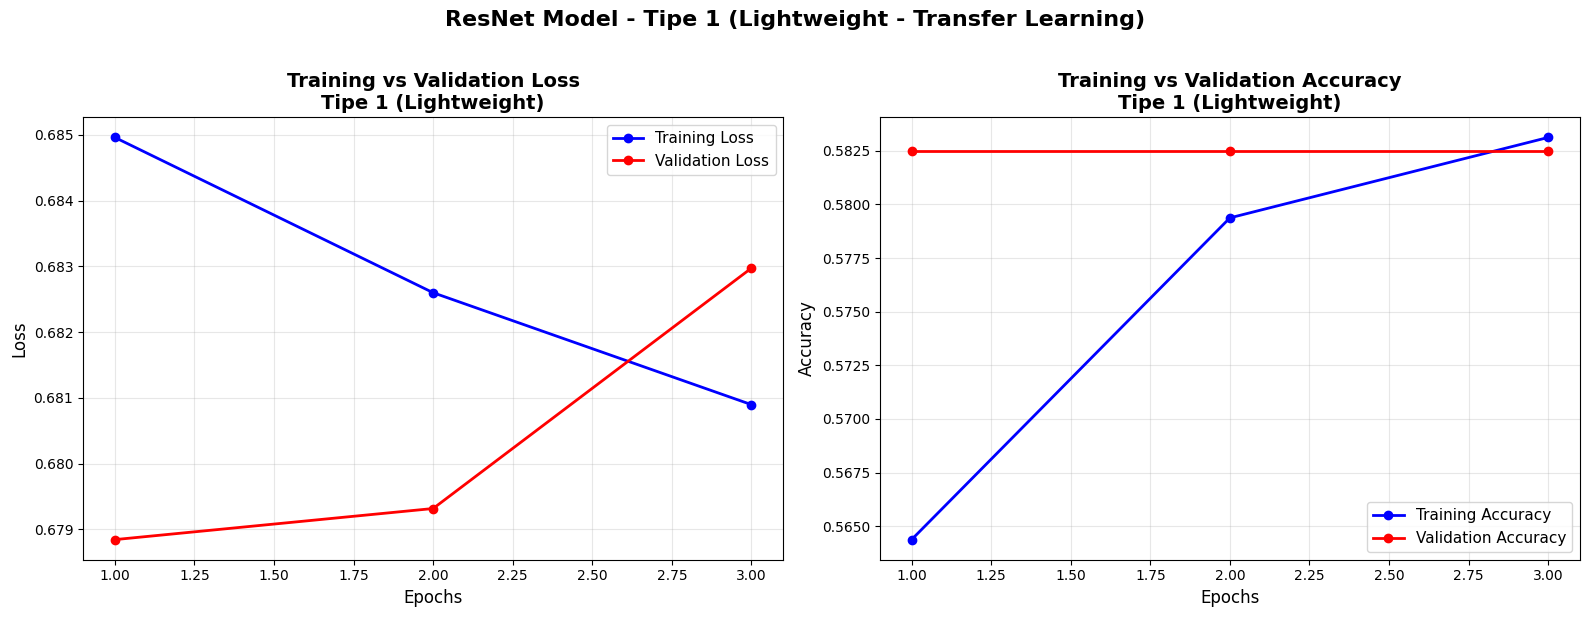


📊 SUMMARY HASIL TRAINING - RESNET TIPE 1
Epochs trained: 3/10
Batch Size: 8 | LR: 0.001 | Dropout: 0.2
------------------------------------------------------------
Final Training Loss      : 0.6809
Final Training Accuracy  : 0.5831 (58.31%)
Final Validation Loss    : 0.6830
Final Validation Accuracy: 0.5825 (58.25%)
Training Duration        : 32.84s (0.55 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [10]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type1 = history_type1.history['loss']
val_loss_values_type1 = history_type1.history['val_loss']
accuracy_values_type1 = history_type1.history['accuracy']
val_accuracy_values_type1 = history_type1.history['val_accuracy']

epochs_range = range(1, len(loss_values_type1) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type1, 'bo-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type1, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 1 (Lightweight)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type1, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type1, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 1 (Lightweight)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('ResNet Model - Tipe 1 (Lightweight - Transfer Learning)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - RESNET TIPE 1")
print("="*60)
print(f"Epochs trained: {len(loss_values_type1)}/{epochs_type1}")
print(f"Batch Size: {batch_size_type1} | LR: 0.001 | Dropout: 0.2")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type1[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type1[-1]:.4f} ({accuracy_values_type1[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type1[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type1[-1]:.4f} ({val_accuracy_values_type1[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type1:.2f}s ({training_duration_type1/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type1[-1] - val_accuracy_values_type1[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

📈 EVALUASI MODEL RESNET - TIPE 1
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.5837 - loss: 0.6786

📊 HASIL EVALUASI FINAL - RESNET TIPE 1
Validation Loss    : 0.6788
Validation Accuracy: 0.5825 (58.25%)

🔮 Melakukan prediksi pada validation set...

📊 Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

      Female       0.58      1.00      0.74       233
        Male       0.00      0.00      0.00       167

    accuracy                           0.58       400
   macro avg       0.29      0.50      0.37       400
weighted avg       0.34      0.58      0.43       400


📊 Confusion Matrix:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


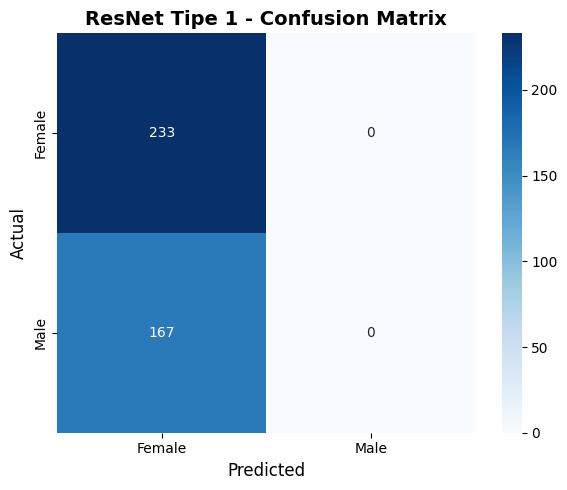


❌ Model ResNet Tipe 1 perlu perbaikan.


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("📈 EVALUASI MODEL RESNET - TIPE 1")
print("="*60)

# === EVALUATE PADA VALIDATION SET ===
loss_type1, accuracy_type1 = model_type1.evaluate(val_images, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - RESNET TIPE 1")
print("="*60)
print(f"Validation Loss    : {loss_type1:.4f}")
print(f"Validation Accuracy: {accuracy_type1:.4f} ({accuracy_type1*100:.2f}%)")
print("="*60)

# === PREDIKSI & CLASSIFICATION REPORT ===
print("\n🔮 Melakukan prediksi pada validation set...")
val_preds = (model_type1.predict(val_images, verbose=0) > 0.5).astype("int32")

print("\n📊 Classification Report:")
print("-"*60)
print(classification_report(val_labels, val_preds, target_names=['Female', 'Male']))

# === CONFUSION MATRIX ===
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'])
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("ResNet Tipe 1 - Confusion Matrix", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Interpretasi hasil
print("\n" + "="*60)
if accuracy_type1 > 0.85:
    print("✅ Model ResNet Tipe 1 memiliki performa BAIK!")
elif accuracy_type1 > 0.75:
    print("⚠️  Model ResNet Tipe 1 cukup baik, masih bisa ditingkatkan.")
else:
    print("❌ Model ResNet Tipe 1 perlu perbaikan.")
print("="*60)

## ResNet - V2

### Build Model ResNet

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def build_resnet_heavy(learning_rate=0.0001, dropout_rate=0.5):
    """
    Membangun ResNet50 dengan Fine-tuning untuk binary classification

    Args:
        learning_rate: Learning rate untuk optimizer (lebih kecil untuk fine-tuning)
        dropout_rate: Dropout rate untuk regularisasi (lebih tinggi)

    Returns:
        model: ResNet50 model yang sudah dikompilasi
    """
    print("Membangun ResNet50 dengan Fine-tuning...")

    # === LOAD PRETRAINED RESNET50 ===
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3)
    )

    # === FINE-TUNING: UNFREEZE BEBERAPA LAYER AKHIR ===
    # Fine-tuning: Unfreeze layer akhir untuk dilatih ulang
    # Ini berbeda dengan Tipe 1 yang freeze semua layer

    # Freeze semua layer dulu
    base_model.trainable = True

    # Hitung total layer
    total_layers = len(base_model.layers)

    # Unfreeze hanya 30 layer terakhir (sekitar 20% dari total)
    # Layer awal tetap frozen karena sudah belajar fitur generic (edges, textures)
    # Layer akhir dilatih ulang untuk fitur spesifik dataset kita
    fine_tune_at = total_layers - 30

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    trainable_layers = sum([1 for layer in base_model.layers if layer.trainable])
    frozen_layers = total_layers - trainable_layers

    print(f"ResNet50 base model loaded (partial fine-tuning)")
    print(f"Total layers: {total_layers}")
    print(f"Frozen layers: {frozen_layers} (layer 0-{fine_tune_at-1})")
    print(f"Trainable layers: {trainable_layers} (layer {fine_tune_at}-{total_layers-1})")

    # === CUSTOM LAYERS ===
    # GlobalAveragePooling2D: Rata-rata feature map
    x = GlobalAveragePooling2D()(base_model.output)

    # Dropout lebih tinggi untuk regularisasi (karena fine-tuning)
    x = Dropout(dropout_rate)(x)

    # Output layer: Binary classification
    output = Dense(1, activation='sigmoid')(x)

    # === BUILD MODEL ===
    model = Model(inputs=base_model.input, outputs=output)

    # === COMPILE MODEL ===
    # Learning rate lebih kecil untuk fine-tuning (jangan rusak pretrained weights)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("="*60)
print("🟢 BUILD MODEL RESNET - TIPE 2 (HEAVY - FINE-TUNING)")
print("="*60)

# Build model dengan hyperparameter Tipe 2
model_type2 = build_resnet_heavy(
    learning_rate=0.0001,  # Learning rate 10x lebih kecil
    dropout_rate=0.5       # Dropout rate lebih tinggi
)

print("\n=== Arsitektur Model ResNet Tipe 2 ===")
model_type2.summary()

# Hitung total parameter
total_params = model_type2.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model_type2.trainable_weights])
frozen_params = total_params - trainable_params

print(f"\n{'='*60}")
print(f"Total parameters    : {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} (30 layer akhir ResNet + custom)")
print(f"Frozen parameters   : {frozen_params:,} (layer awal ResNet)")
print(f"{'='*60}")

print("\n📌 Note: Fine-tuning - {:.2f}% parameter dilatih (lebih banyak dari Tipe 1)".format(
    (trainable_params / total_params) * 100
))

🟢 BUILD MODEL RESNET - TIPE 2 (HEAVY - FINE-TUNING)
Membangun ResNet50 dengan Fine-tuning...
ResNet50 base model loaded (partial fine-tuning)
Total layers: 175
Frozen layers: 145 (layer 0-144)
Trainable layers: 30 (layer 145-174)

=== Arsitektur Model ResNet Tipe 2 ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 14,452,225 (55.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)


Total parameters    : 23,589,761
Trainable parameters: 14,452,225 (30 layer akhir ResNet + custom)
Frozen parameters   : 9,137,536 (layer awal ResNet)

📌 Note: Fine-tuning - 61.26% parameter dilatih (lebih banyak dari Tipe 1)


### Compile & Train Model

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
import time

# === KONFIGURASI TRAINING TIPE 2 ===
config_name = "Heavy - Fine-tuning"
batch_size_type2 = 16  # Batch lebih besar (2x dari Tipe 1)
epochs_type2 = 20      # Epochs lebih banyak (2x dari Tipe 1)

print("="*60)
print("🟢 TRAINING RESNET - TIPE 2 (HEAVY - FINE-TUNING)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type2}")
print(f"Batch Size: {batch_size_type2}")
print(f"Learning Rate: 0.0001")
print(f"Dropout Rate: 0.5")
print("-"*60)
print(f"Total training samples: {len(train_images):,}")
print(f"Total validation samples: {len(val_images):,}")
print(f"Steps per epoch: {len(train_images) // batch_size_type2}")
print("="*60)

print("\n📌 REASONING TIPE 2 (Heavy - Fine-tuning):")
print("-"*60)
print("""
- Fine-tuning: Unfreeze 30 layer terakhir ResNet50
  → Layer awal frozen (fitur generic: edges, textures)
  → Layer akhir dilatih (fitur spesifik: face features)
  → Butuh learning rate LEBIH KECIL (jangan rusak pretrained weights)

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Fine-tuning perlu LR kecil untuk gradual adaptation
  → LR besar bisa merusak pretrained weights
  → Konvergensi lebih lambat tapi lebih stabil

- Batch Size: 16 (2x dari Tipe 1)
  → Batch lebih besar = gradient update lebih stabil
  → Trade-off: Butuh RAM lebih (tapi masih OK untuk Colab)

- Epochs: 20 (2x dari Tipe 1)
  → Fine-tuning butuh waktu lebih lama untuk konvergen
  → Early stopping tetap aktif untuk cegah overfitting

- Dropout: 0.5 (lebih tinggi dari Tipe 1)
  → Fine-tuning lebih rentan overfitting (train lebih banyak parameter)
  → Dropout tinggi untuk regularisasi

- Transfer Learning vs Fine-tuning:
  → Tipe 1: Freeze semua, cepat, data sedikit cukup
  → Tipe 2: Fine-tune layer akhir, lebih akurat, butuh tuning careful

✅ COCOK UNTUK: Maximum accuracy, production deployment
""")
print("="*60)

# === EARLY STOPPING CALLBACK ===
# Patience lebih besar untuk fine-tuning (konvergen lebih lambat)
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,                 # Tunggu 3 epoch (lebih sabar dari Tipe 1)
    restore_best_weights=True,
    verbose=1
)

# Catat waktu mulai training
start_time = time.time()

print("\n🚀 Training ResNet Tipe 2 dimulai...")
print("-"*60)

# Train model
history_type2 = model_type2.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=epochs_type2,
    batch_size=batch_size_type2,
    callbacks=[early_stop],
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_type2 = end_time - start_time

print("\n" + "="*60)
print("✅ TRAINING RESNET TIPE 2 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_type2:.2f} detik ({training_duration_type2/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_type2.history['accuracy'][-1]:.4f} ({history_type2.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_type2.history['val_accuracy'][-1]:.4f} ({history_type2.history['val_accuracy'][-1]*100:.2f}%)")
print(f"🛑 Early stopped at epoch: {len(history_type2.history['loss'])}/{epochs_type2}")
print("="*60)

🟢 TRAINING RESNET - TIPE 2 (HEAVY - FINE-TUNING)
Konfigurasi: Heavy - Fine-tuning
------------------------------------------------------------
Epochs: 20
Batch Size: 16
Learning Rate: 0.0001
Dropout Rate: 0.5
------------------------------------------------------------
Total training samples: 1,600
Total validation samples: 400
Steps per epoch: 100

📌 REASONING TIPE 2 (Heavy - Fine-tuning):
------------------------------------------------------------

- Fine-tuning: Unfreeze 30 layer terakhir ResNet50
  → Layer awal frozen (fitur generic: edges, textures)
  → Layer akhir dilatih (fitur spesifik: face features)
  → Butuh learning rate LEBIH KECIL (jangan rusak pretrained weights)

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Fine-tuning perlu LR kecil untuk gradual adaptation
  → LR besar bisa merusak pretrained weights
  → Konvergensi lebih lambat tapi lebih stabil

- Batch Size: 16 (2x dari Tipe 1)
  → Batch lebih besar = gradient update lebih stabil
  → Trade-off: Butuh 

### Plot Training History

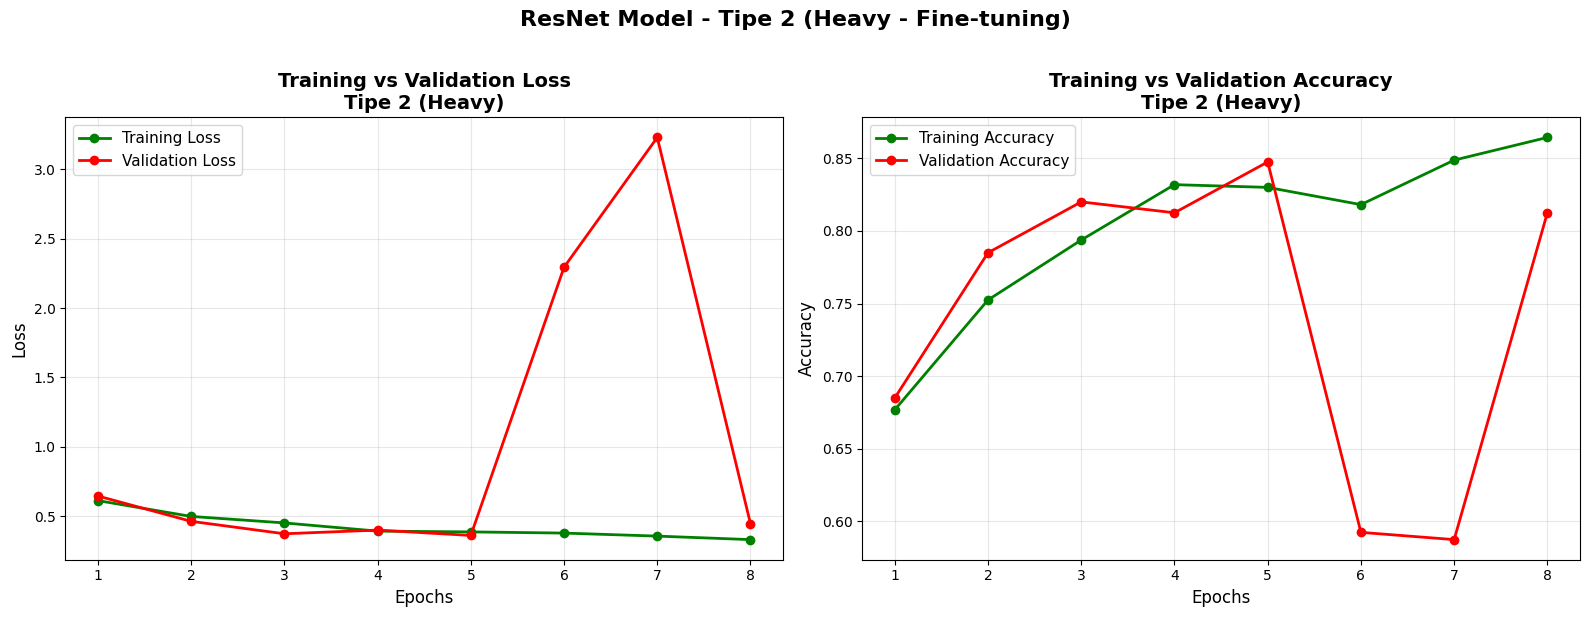


📊 SUMMARY HASIL TRAINING - RESNET TIPE 2
Epochs trained: 8/20
Batch Size: 16 | LR: 0.0001 | Dropout: 0.5
------------------------------------------------------------
Final Training Loss      : 0.3318
Final Training Accuracy  : 0.8644 (86.44%)
Final Validation Loss    : 0.4456
Final Validation Accuracy: 0.8125 (81.25%)
Training Duration        : 69.42s (1.16 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [14]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type2 = history_type2.history['loss']
val_loss_values_type2 = history_type2.history['val_loss']
accuracy_values_type2 = history_type2.history['accuracy']
val_accuracy_values_type2 = history_type2.history['val_accuracy']

epochs_range = range(1, len(loss_values_type2) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type2, 'go-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type2, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 2 (Heavy)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type2, 'go-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type2, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 2 (Heavy)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('ResNet Model - Tipe 2 (Heavy - Fine-tuning)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - RESNET TIPE 2")
print("="*60)
print(f"Epochs trained: {len(loss_values_type2)}/{epochs_type2}")
print(f"Batch Size: {batch_size_type2} | LR: 0.0001 | Dropout: 0.5")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type2[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type2[-1]:.4f} ({accuracy_values_type2[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type2[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type2[-1]:.4f} ({val_accuracy_values_type2[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type2:.2f}s ({training_duration_type2/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type2[-1] - val_accuracy_values_type2[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

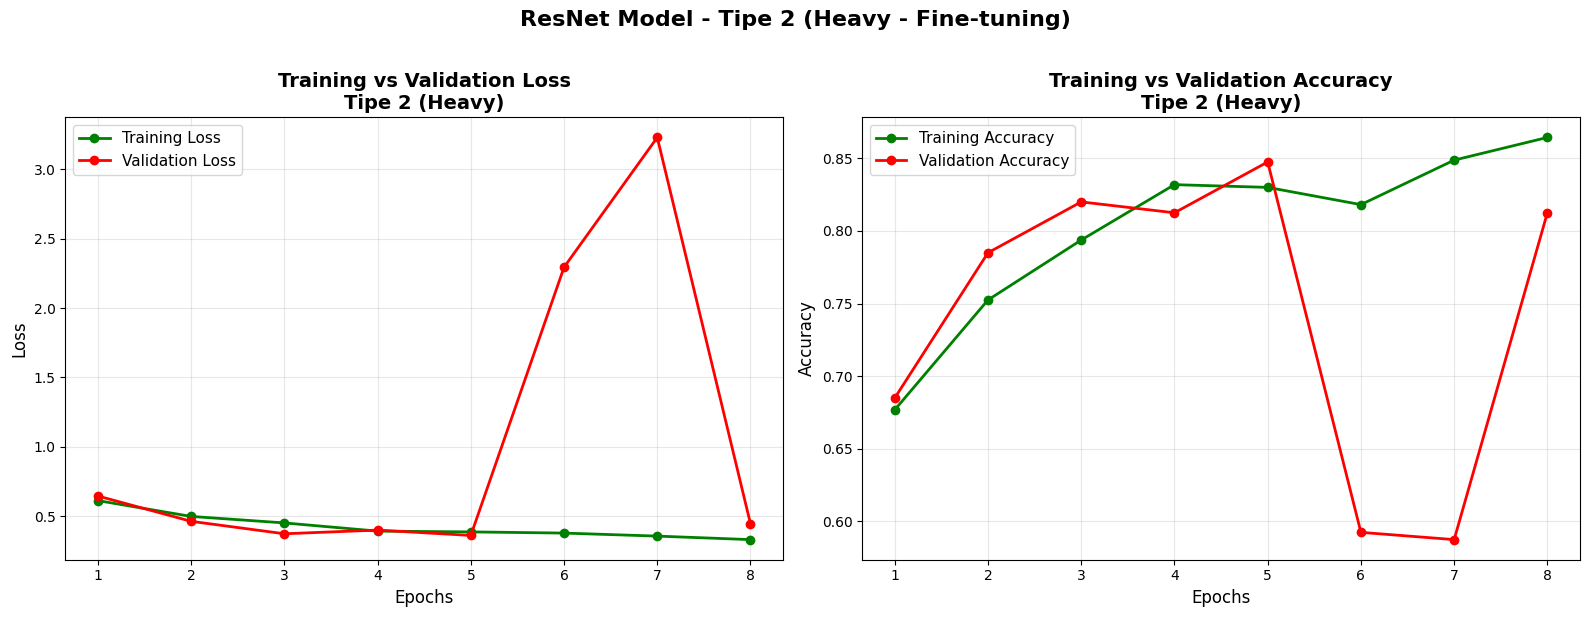


📊 SUMMARY HASIL TRAINING - RESNET TIPE 2
Epochs trained: 8/20
Batch Size: 16 | LR: 0.0001 | Dropout: 0.5
------------------------------------------------------------
Final Training Loss      : 0.3318
Final Training Accuracy  : 0.8644 (86.44%)
Final Validation Loss    : 0.4456
Final Validation Accuracy: 0.8125 (81.25%)
Training Duration        : 69.42s (1.16 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [15]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type2 = history_type2.history['loss']
val_loss_values_type2 = history_type2.history['val_loss']
accuracy_values_type2 = history_type2.history['accuracy']
val_accuracy_values_type2 = history_type2.history['val_accuracy']

epochs_range = range(1, len(loss_values_type2) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type2, 'go-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type2, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 2 (Heavy)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type2, 'go-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type2, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 2 (Heavy)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('ResNet Model - Tipe 2 (Heavy - Fine-tuning)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - RESNET TIPE 2")
print("="*60)
print(f"Epochs trained: {len(loss_values_type2)}/{epochs_type2}")
print(f"Batch Size: {batch_size_type2} | LR: 0.0001 | Dropout: 0.5")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type2[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type2[-1]:.4f} ({accuracy_values_type2[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type2[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type2[-1]:.4f} ({val_accuracy_values_type2[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type2:.2f}s ({training_duration_type2/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type2[-1] - val_accuracy_values_type2[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

## Test (V1 + V2)

🔵🟢 TEST PREDIKSI - RESNET TIPE 1 & TIPE 2
Upload gambar sekali, test di kedua model sekaligus
------------------------------------------------------------


Saving LUCINTA.webp to LUCINTA.webp

📷 Memproses gambar: "LUCINTA.webp"
Ukuran file: 6,030 bytes

📊 HASIL PREDIKSI UNTUK: LUCINTA.webp
🔵 RESNET TIPE 1 (Transfer Learning):
   Prediksi: Female
   Prob Male: 0.4007 (40.07%)
   Confidence: 0.5993 (59.93%)

🟢 RESNET TIPE 2 (Fine-tuning):
   Prediksi: Female
   Prob Male: 0.4973 (49.73%)
   Confidence: 0.5027 (50.27%)

✅ KEDUA MODEL SEPAKAT: Female


/tmp/ipython-input-3358378426.py:135: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3358378426.py:135: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


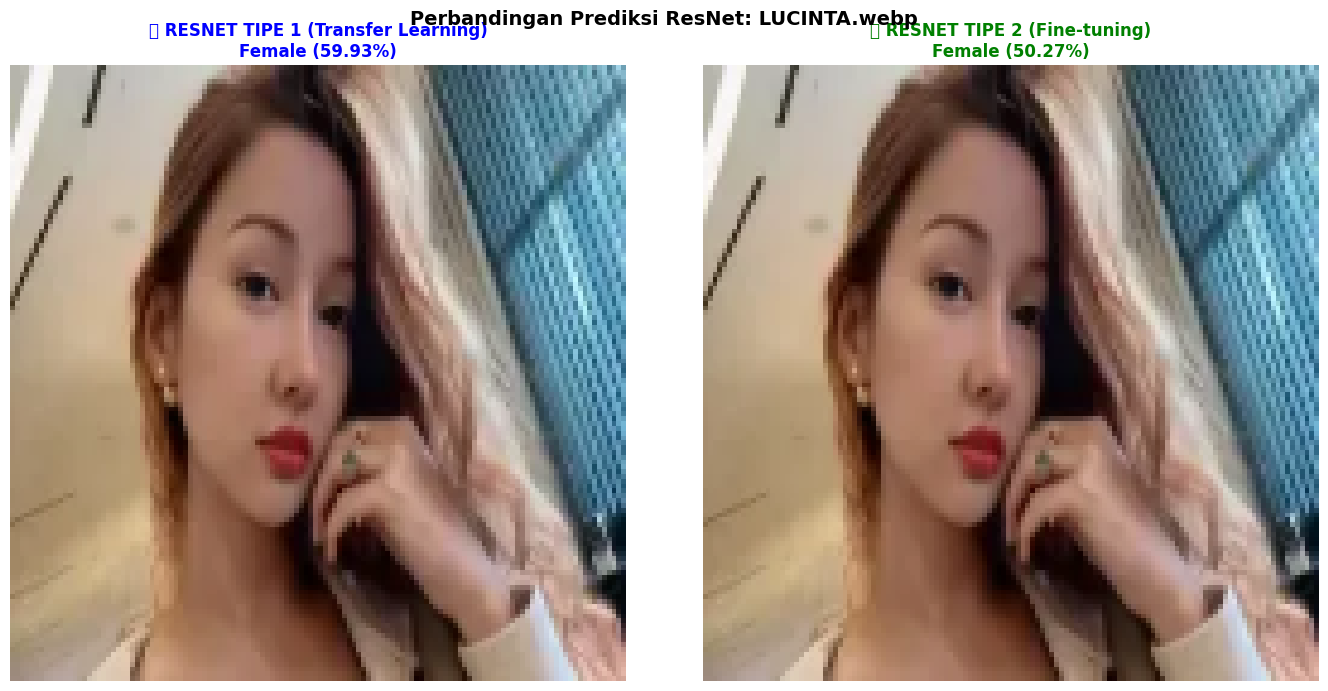


✅ Prediksi kedua model selesai!


In [16]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("🔵🟢 TEST PREDIKSI - RESNET TIPE 1 & TIPE 2")
print("="*60)
print("Upload gambar sekali, test di kedua model sekaligus")
print("-"*60)

# Upload gambar dari komputer lokal
uploaded = files.upload()

# Simpan hasil prediksi untuk perbandingan
predictions_comparison = []

# Proses setiap gambar yang diupload
for fn in uploaded.keys():
    print(f'\n{"="*60}')
    print(f'📷 Memproses gambar: "{fn}"')
    print(f'Ukuran file: {len(uploaded[fn]):,} bytes')
    print(f'{"="*60}')

    # Baca gambar
    image_path = fn
    img = cv2.imread(image_path)

    if img is None:
        print(f"❌ Error: Tidak dapat membaca gambar {image_path}")
        continue

    # === PREPROCESSING (SAMA DENGAN TRAINING) ===

    # 1. Resize ke ukuran input model (128x128 untuk ResNet)
    target_size = (128, 128)
    img_resized = cv2.resize(img, target_size)

    # 2. Konversi BGR (OpenCV) ke RGB (sesuai training)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # 3. Normalisasi: ubah range piksel dari [0, 255] ke [0, 1]
    img_normalized = img_rgb.astype('float32') / 255.0

    # 4. Tambah dimensi batch: (128, 128, 3) -> (1, 128, 128, 3)
    img_input = np.expand_dims(img_normalized, axis=0)

    # === PREDIKSI DENGAN KEDUA MODEL ===
    results = {}

    # Prediksi Model Tipe 1
    if 'model_type1' in globals():
        pred1 = model_type1.predict(img_input, verbose=0)
        prob_male_1 = pred1[0][0]
        class_1 = "Male" if prob_male_1 > 0.5 else "Female"
        conf_1 = prob_male_1 if prob_male_1 > 0.5 else (1 - prob_male_1)
        results['type1'] = {
            'prob_male': prob_male_1,
            'class': class_1,
            'confidence': conf_1
        }
    else:
        print("⚠️  Model Tipe 1 tidak ditemukan, skip prediksi Tipe 1")

    # Prediksi Model Tipe 2
    if 'model_type2' in globals():
        pred2 = model_type2.predict(img_input, verbose=0)
        prob_male_2 = pred2[0][0]
        class_2 = "Male" if prob_male_2 > 0.5 else "Female"
        conf_2 = prob_male_2 if prob_male_2 > 0.5 else (1 - prob_male_2)
        results['type2'] = {
            'prob_male': prob_male_2,
            'class': class_2,
            'confidence': conf_2
        }
    else:
        print("⚠️  Model Tipe 2 tidak ditemukan, skip prediksi Tipe 2")

    # Simpan hasil untuk tabel perbandingan
    if 'type1' in results and 'type2' in results:
        predictions_comparison.append({
            'filename': fn,
            'type1_prob_male': results['type1']['prob_male'],
            'type1_class': results['type1']['class'],
            'type1_conf': results['type1']['confidence'],
            'type2_prob_male': results['type2']['prob_male'],
            'type2_class': results['type2']['class'],
            'type2_conf': results['type2']['confidence']
        })

    # === TAMPILKAN HASIL SIDE-BY-SIDE ===
    print(f"\n📊 HASIL PREDIKSI UNTUK: {fn}")
    print(f"="*60)

    if 'type1' in results:
        print(f"🔵 RESNET TIPE 1 (Transfer Learning):")
        print(f"   Prediksi: {results['type1']['class']}")
        print(f"   Prob Male: {results['type1']['prob_male']:.4f} ({results['type1']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type1']['confidence']:.4f} ({results['type1']['confidence']*100:.2f}%)")

    if 'type2' in results:
        print(f"\n🟢 RESNET TIPE 2 (Fine-tuning):")
        print(f"   Prediksi: {results['type2']['class']}")
        print(f"   Prob Male: {results['type2']['prob_male']:.4f} ({results['type2']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type2']['confidence']:.4f} ({results['type2']['confidence']*100:.2f}%)")

    # Cek apakah prediksi sama atau beda
    if 'type1' in results and 'type2' in results:
        if results['type1']['class'] == results['type2']['class']:
            print(f"\n✅ KEDUA MODEL SEPAKAT: {results['type1']['class']}")
        else:
            print(f"\n⚠️  PREDIKSI BERBEDA!")
            print(f"   Tipe 1: {results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)")
            print(f"   Tipe 2: {results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)")

    print(f"="*60)

    # === VISUALISASI SIDE-BY-SIDE ===
    if 'type1' in results and 'type2' in results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Model Tipe 1
        axes[0].imshow(img_rgb)
        axes[0].set_title(f"🔵 RESNET TIPE 1 (Transfer Learning)\n{results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='blue')
        axes[0].axis('off')

        # Model Tipe 2
        axes[1].imshow(img_rgb)
        axes[1].set_title(f"🟢 RESNET TIPE 2 (Fine-tuning)\n{results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='green')
        axes[1].axis('off')

        plt.suptitle(f"Perbandingan Prediksi ResNet: {fn}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

print("\n" + "="*60)
print("✅ Prediksi kedua model selesai!")
print("="*60)

# AlexNet

## Setup Kaggle di Colab

In [3]:
# Install Kaggle
!pip install kaggle -q
import os
import sys

# Buat direktori .kaggle jika belum ada
!mkdir -p ~/.kaggle

# Cek apakah file kaggle.json sudah diupload
if os.path.exists('/content/kaggle.json'):
    # Pindahkan kaggle.json ke direktori .kaggle
    !mv /content/kaggle.json ~/.kaggle/
    # Set permission file agar secure
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json berhasil dikonfigurasi.")
else:
    print("kaggle.json tidak ditemukan di /content/. Silakan upload file kaggle.json terlebih dahulu.")

kaggle.json berhasil dikonfigurasi.


## Download Dataset dari Kaggle

In [4]:
# Download dataset CelebA 64x64 dari Kaggle
!kaggle datasets download -d therealcyberlord/50k-celeba-dataset-64x64

Dataset URL: https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64
License(s): unknown
  0% 0.00/78.1M [00:00<?, ?B/s]
100% 78.1M/78.1M [00:00<00:00, 1.36GB/s]


## Extract Dataset

In [5]:
import zipfile
import os

# Path file zip yang telah didownload
zip_file_path = '/content/50k-celeba-dataset-64x64.zip'

# Direktori tujuan ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'

# Buat folder ekstraksi jika belum ada
os.makedirs(extracted_path, exist_ok=True)

# Ekstrak file zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Dataset berhasil diekstrak.")
except FileNotFoundError:
    print(f"Error: File {zip_file_path} tidak ditemukan. Pastikan download berhasil.")
except zipfile.BadZipFile:
    print(f"Error: File {zip_file_path} bukan zip yang valid. Download mungkin corrupt.")
except Exception as e:
    print(f"Error saat ekstraksi: {e}")

Dataset berhasil diekstrak.


## Cek Isi Folder

In [6]:
import os

# Tampilkan isi direktori hasil ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'
print("Isi folder ekstraksi:")
print(os.listdir(extracted_path))

Isi folder ekstraksi:
['50k']


## Download Attribute File (Label)


In [7]:
# Download file atribut dari GitHub (alternatif jika gagal)
# Opsional: Bisa juga download manual dari Google Drive
# Link Google Drive: https://drive.google.com/drive/folders/1AA21MR8GeQdnOVgmNcbxCrbAjL1udj0l

import requests
import os

# URL file atribut CelebA
attribute_file_url = "https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt"
attribute_file_path = "/content/list_attr_celeba.txt"

print(f"Mencoba download file atribut dari: {attribute_file_url}")

try:
    response = requests.get(attribute_file_url, stream=True)
    response.raise_for_status()  # Raise error jika status 4xx atau 5xx

    with open(attribute_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"File atribut berhasil didownload ke: {attribute_file_path}")

except requests.exceptions.RequestException as e:
    print(f"Error saat download file atribut: {e}")
    print("Tidak dapat mendownload file dari URL yang diberikan.")
    print("Silakan download manual dari Google Drive dan upload ke Colab.")
except Exception as e:
    print(f"Error saat memproses file atribut: {e}")

Mencoba download file atribut dari: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Error saat download file atribut: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Tidak dapat mendownload file dari URL yang diberikan.
Silakan download manual dari Google Drive dan upload ke Colab.


## Import Library

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import random
import os

print("✅ Library berhasil diimport")
print(f"TensorFlow version: {tf.__version__}")

✅ Library berhasil diimport
TensorFlow version: 2.19.0


## Reproducibility & Config

In [9]:
# === KONFIGURASI REPRODUCIBILITY ===
# Set random seed untuk reproducibility (hasil sama setiap run)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("="*60)
print("🔵 ALEXNET TIPE 1 - LIGHTWEIGHT")
print("="*60)
print(f"Random seed set to: {SEED}")

# === KONFIGURASI HYPERPARAMETER ===
INPUT_SHAPE = (128, 128, 3)  # Input size AlexNet (lebih besar dari VGG 64x64)
LEARNING_RATE = 1e-3         # 0.001
DROPOUT_RATE = 0.3           # Dropout rate moderate
EPOCHS = 10
BATCH_SIZE = 32

print("\n📌 KONFIGURASI ALEXNET TIPE 1:")
print(f"Input Shape: {INPUT_SHAPE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print("="*60)

🔵 ALEXNET TIPE 1 - LIGHTWEIGHT
Random seed set to: 42

📌 KONFIGURASI ALEXNET TIPE 1:
Input Shape: (128, 128, 3)
Learning Rate: 0.001
Dropout Rate: 0.3
Epochs: 10
Batch Size: 32


## Load Dataset & Preprocessing


In [10]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

# Path direktori gambar dan file atribut
img_dir = "/content/celeba_dataset_kaggle/50k"
attr_path = "/content/list_attr_celeba.txt"

print("Memulai loading dataset...")

# === VALIDASI DIREKTORI GAMBAR ===
if not os.path.exists(img_dir):
    print(f"❌ Error: Direktori gambar tidak ditemukan di {img_dir}")
    images, labels = np.array([]), np.array([])
else:
    # List semua file gambar
    image_files_in_dir = [f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')]

    if not image_files_in_dir:
        print(f"❌ Error: Tidak ada file gambar di {img_dir}")
        images, labels = np.array([]), np.array([])
    else:
        print(f"✅ Ditemukan {len(image_files_in_dir)} file gambar di {img_dir}")

        # === LOAD FILE ATRIBUT ===
        try:
            # Load attribute file
            attributes = pd.read_csv(attr_path, skiprows=1, sep=r'\s+', index_col=0)
            print(f"✅ File atribut berhasil diload dari {attr_path}")

            # === SAMPLE DATA ===
            # AlexNet pakai sample lebih kecil (sama dengan ResNet)
            sample_size = 2000  # Lebih ringan untuk Colab Free

            # Filter: hanya ambil yang ada gambarnya
            available_image_ids = [os.path.basename(f) for f in image_files_in_dir]
            attributes_available = attributes[attributes.index.isin(available_image_ids)]

            if len(attributes_available) < sample_size:
                print(f"⚠️  Warning: Hanya {len(attributes_available)} gambar dengan atribut tersedia.")
                print(f"   Loading semua data yang tersedia.")
                sample_data = attributes_available
            else:
                sample_data = attributes_available.sample(sample_size, random_state=SEED)

            print(f"\n📦 Sample data: {len(sample_data)} gambar")

            # === LOAD & PREPROCESS GAMBAR ===
            images = []
            labels = []

            print("\n🔄 Loading dan preprocessing gambar...")
            for idx, (filename, row) in enumerate(sample_data.iterrows()):
                img_path = os.path.join(img_dir, filename)
                img = cv2.imread(img_path)

                if img is not None:
                    # Resize ke 128x128 (AlexNet original pakai 227x227, tapi 128x128 cukup)
                    img = cv2.resize(img, (128, 128))

                    # Konversi BGR ke RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Normalisasi ke [0, 1]
                    img = img / 255.0

                    images.append(img)
                    labels.append(1 if row['Male'] == 1 else 0)
                else:
                    print(f"⚠️  Warning: Tidak dapat load {img_path}")

                # Progress indicator setiap 200 gambar
                if (idx + 1) % 200 == 0:
                    print(f"   Progress: {idx + 1}/{len(sample_data)} gambar")

            # Konversi ke numpy array
            images = np.array(images, dtype=np.float32)
            labels = np.array(labels)

            print(f"\n{'='*60}")
            print("✅ BERHASIL LOAD DATA")
            print(f"{'='*60}")
            print(f"Total gambar: {len(images)}")
            print(f"Shape gambar: {images.shape}")
            print(f"Shape label: {labels.shape}")
            print(f"Range nilai piksel: [{images.min():.2f}, {images.max():.2f}]")
            print(f"Distribusi label: Female={int((labels==0).sum())}, Male={int((labels==1).sum())}")
            print(f"{'='*60}")

        except FileNotFoundError:
            print(f"❌ Error: File atribut tidak ditemukan di {attr_path}")
            images, labels = np.array([]), np.array([])
        except KeyError:
            print(f"❌ Error: Kolom 'Male' tidak ditemukan di file atribut.")
            images, labels = np.array([]), np.array([])
        except Exception as e:
            print(f"❌ Error tidak terduga saat loading data: {e}")
            images, labels = np.array([]), np.array([])

# === SPLIT DATA ===
if len(images) > 0:
    print("\n🔄 Melakukan split data...")

    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels,
        test_size=0.2,       # 20% untuk validation
        random_state=SEED,   # Reproducibility
        stratify=labels      # Jaga keseimbangan kelas
    )

    print(f"\n{'='*60}")
    print("=== Hasil Split Data ===")
    print(f"{'='*60}")
    print(f"Training set   : {train_images.shape}")
    print(f"Validation set : {val_images.shape}")
    print(f"Training labels: {train_labels.shape}")
    print(f"Validation labels: {val_labels.shape}")
    print(f"\nDistribusi Training   - Female: {(train_labels==0).sum()}, Male: {(train_labels==1).sum()}")
    print(f"Distribusi Validation - Female: {(val_labels==0).sum()}, Male: {(val_labels==1).sum()}")
    print(f"{'='*60}")
    print("\n✅ Data ready untuk training!")

else:
    print("\n❌ Data loading gagal. Tidak dapat melanjutkan.")
    train_images, val_images, train_labels, val_labels = None, None, None, None

Memulai loading dataset...
✅ Ditemukan 50000 file gambar di /content/celeba_dataset_kaggle/50k
✅ File atribut berhasil diload dari /content/list_attr_celeba.txt

📦 Sample data: 2000 gambar

🔄 Loading dan preprocessing gambar...
   Progress: 200/2000 gambar
   Progress: 400/2000 gambar
   Progress: 600/2000 gambar
   Progress: 800/2000 gambar
   Progress: 1000/2000 gambar
   Progress: 1200/2000 gambar
   Progress: 1400/2000 gambar
   Progress: 1600/2000 gambar
   Progress: 1800/2000 gambar
   Progress: 2000/2000 gambar

✅ BERHASIL LOAD DATA
Total gambar: 2000
Shape gambar: (2000, 128, 128, 3)
Shape label: (2000,)
Range nilai piksel: [0.00, 1.00]
Distribusi label: Female=1164, Male=836

🔄 Melakukan split data...

=== Hasil Split Data ===
Training set   : (1600, 128, 128, 3)
Validation set : (400, 128, 128, 3)
Training labels: (1600,)
Validation labels: (400,)

Distribusi Training   - Female: 931, Male: 669
Distribusi Validation - Female: 233, Male: 167

✅ Data ready untuk training!


## Safety Checks for Data


In [11]:
# === VALIDASI DATA SEBELUM TRAINING ===
print("="*60)
print("🔍 SAFETY CHECKS FOR DATA")
print("="*60)

# Cek keberadaan variabel
if 'train_images' not in globals() or train_images is None:
    raise RuntimeError("train_images not found — run the data loading/splitting cells first.")
if 'val_images' not in globals() or val_images is None:
    raise RuntimeError("val_images not found — run the data loading/splitting cells first.")
if 'train_labels' not in globals() or train_labels is None:
    raise RuntimeError("train_labels not found — run the data loading/splitting cells first.")
if 'val_labels' not in globals() or val_labels is None:
    raise RuntimeError("val_labels not found — run the data loading/splitting cells first.")

print("✅ All data variables found")

# Pastikan tipe data float32 dan sudah di-scale [0, 1]
if train_images.dtype != np.float32:
    print("⚠️  Converting images to float32 and scaling to [0, 1]")
    train_images = train_images.astype('float32') / 255.0
    val_images = val_images.astype('float32') / 255.0
else:
    print("✅ Images already float32 and scaled")

# Convert potential -1/1 labels to 0/1 (jika ada)
unique_labels = np.unique(np.concatenate([train_labels.flatten(), val_labels.flatten()]))
if set(unique_labels.tolist()).issuperset({-1, 1}):
    print("⚠️  Converting labels from -1/1 to 0/1")
    train_labels = np.where(train_labels == -1, 0, 1)
    val_labels = np.where(val_labels == -1, 0, 1)
else:
    print("✅ Labels already in 0/1 format")

print("\n📊 Data ready — shapes:")
print(f"   train_images: {train_images.shape}")
print(f"   val_images: {val_images.shape}")
print(f"   train_labels unique: {np.unique(train_labels)}")
print(f"   val_labels unique: {np.unique(val_labels)}")
print("="*60)

🔍 SAFETY CHECKS FOR DATA
✅ All data variables found
✅ Images already float32 and scaled
✅ Labels already in 0/1 format

📊 Data ready — shapes:
   train_images: (1600, 128, 128, 3)
   val_images: (400, 128, 128, 3)
   train_labels unique: [0 1]
   val_labels unique: [0 1]


## AlexNex - V1

### Build AlexNet Model

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def build_alexnet(input_shape=INPUT_SHAPE, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE):
    """
    Membangun AlexNet-like model untuk binary classification

    AlexNet adalah CNN landmark (2012, ImageNet winner) dengan karakteristik:
    - Large kernels di awal (11x11, 5x5)
    - Multiple conv layers dengan ReLU
    - Max pooling untuk downsampling
    - Fully connected layers dengan dropout

    Args:
        input_shape: Ukuran input (Height, Width, Channels)
        dropout_rate: Dropout rate untuk regularisasi
        learning_rate: Learning rate untuk optimizer

    Returns:
        model: AlexNet model yang sudah dikompilasi
    """

    model = models.Sequential([
        # === CONV BLOCK 1 ===
        # Conv1: Large kernel 11x11, stride 4 untuk reduce dimensi cepat
        layers.Conv2D(96, (11, 11), strides=(4, 4), padding='same',
                      activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),  # Stabilkan training
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # === CONV BLOCK 2 ===
        # Conv2: Kernel 5x5
        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # === CONV BLOCK 3-5 ===
        # Conv3-5: Kernel 3x3 (lebih kecil, mirip VGG)
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # === FULLY CONNECTED HEAD ===
        # Flatten feature maps ke 1D vector
        layers.Flatten(),

        # FC1: 512 neurons (dikurangi dari AlexNet original 4096 untuk dataset kecil)
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),  # Regularisasi

        # FC2: 512 neurons
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),

        # === OUTPUT LAYER ===
        # Binary classification: Male/Female
        layers.Dense(1, activation='sigmoid')
    ])

    # === COMPILE MODEL ===
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("="*60)
print("🔵 BUILD MODEL ALEXNET - TIPE 1 (LIGHTWEIGHT)")
print("="*60)

# Build model
alexnet = build_alexnet()

print("\n=== Arsitektur Model AlexNet Tipe 1 ===")
alexnet.summary()

# Hitung total parameter
total_params = alexnet.count_params()
print(f"\n{'='*60}")
print(f"Total parameters: {total_params:,}")
print(f"{'='*60}")

print("\n📌 Note AlexNet:")
print("- AlexNet (2012) adalah CNN landmark yang memenangkan ImageNet")
print("- Karakteristik: Large kernels (11x11, 5x5), deep FC layers")
print("- Original AlexNet: 227x227 input, 4096 FC neurons")
print("- Tipe 1 ini: 128x128 input, 512 FC neurons (lebih kecil untuk dataset 2K)")

🔵 BUILD MODEL ALEXNET - TIPE 1 (LIGHTWEIGHT)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Arsitektur Model AlexNet Tipe 1 ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,109,441 (23.31 MB)

 Trainable params: 6,108,737 (23.30 MB)

 Non-trainable params: 704 (2.75 KB)


Total parameters: 6,109,441

📌 Note AlexNet:
- AlexNet (2012) adalah CNN landmark yang memenangkan ImageNet
- Karakteristik: Large kernels (11x11, 5x5), deep FC layers
- Original AlexNet: 227x227 input, 4096 FC neurons
- Tipe 1 ini: 128x128 input, 512 FC neurons (lebih kecil untuk dataset 2K)


### Train Model

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
import time

print("="*60)
print("🔵 TRAINING ALEXNET - TIPE 1 (LIGHTWEIGHT)")
print("="*60)
print(f"Konfigurasi: Lightweight")
print("-"*60)
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print("-"*60)
print(f"Total training samples: {len(train_images):,}")
print(f"Total validation samples: {len(val_images):,}")
print(f"Steps per epoch: {len(train_images) // BATCH_SIZE}")
print("="*60)

print("\n📌 REASONING TIPE 1 (Lightweight):")
print("-"*60)
print("""
- AlexNet: CNN klasik, train from scratch
  → Large kernels (11x11, 5x5) untuk capture fitur global
  → Deep FC layers (512-512) untuk klasifikasi
  → BatchNorm untuk stabilkan training

- Learning Rate: 0.001
  → Standard learning rate untuk Adam
  → Balance antara speed dan stability

- Batch Size: 32
  → Standard batch size, balance memory & convergence
  → AlexNet lebih ringan dari ResNet/GoogleNet

- Dropout: 0.3
  → Moderate regularisasi
  → Cegah overfitting di FC layers

- AlexNet vs VGG vs GoogleNet vs ResNet:
  → AlexNet: Large kernels, deep FC, train from scratch
  → VGG: Small kernels (3x3), deeper, train from scratch
  → GoogleNet: Inception module, efficient
  → ResNet: Skip connection, transfer learning

✅ COCOK UNTUK: Baseline AlexNet, comparison dengan modern CNN
""")
print("="*60)

# === EARLY STOPPING CALLBACK ===
es = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# Catat waktu mulai training
start_time = time.time()

print("\n🚀 Starting AlexNet training...")
print("-"*60)

# Train model
history_alex = alexnet.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration = end_time - start_time

print("\n" + "="*60)
print("✅ ALEXNET TRAINING FINISHED!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration:.2f} detik ({training_duration/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_alex.history['accuracy'][-1]:.4f} ({history_alex.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_alex.history['val_accuracy'][-1]:.4f} ({history_alex.history['val_accuracy'][-1]*100:.2f}%)")
print(f"🛑 Stopped at epoch: {len(history_alex.history['loss'])}/{EPOCHS}")
print("="*60)

🔵 TRAINING ALEXNET - TIPE 1 (LIGHTWEIGHT)
Konfigurasi: Lightweight
------------------------------------------------------------
Epochs: 10
Batch Size: 32
Learning Rate: 0.001
Dropout Rate: 0.3
------------------------------------------------------------
Total training samples: 1,600
Total validation samples: 400
Steps per epoch: 50

📌 REASONING TIPE 1 (Lightweight):
------------------------------------------------------------

- AlexNet: CNN klasik, train from scratch
  → Large kernels (11x11, 5x5) untuk capture fitur global
  → Deep FC layers (512-512) untuk klasifikasi
  → BatchNorm untuk stabilkan training

- Learning Rate: 0.001
  → Standard learning rate untuk Adam
  → Balance antara speed dan stability

- Batch Size: 32
  → Standard batch size, balance memory & convergence
  → AlexNet lebih ringan dari ResNet/GoogleNet

- Dropout: 0.3
  → Moderate regularisasi
  → Cegah overfitting di FC layers

- AlexNet vs VGG vs GoogleNet vs ResNet:
  → AlexNet: Large kernels, deep FC, train f

### Plot Training History

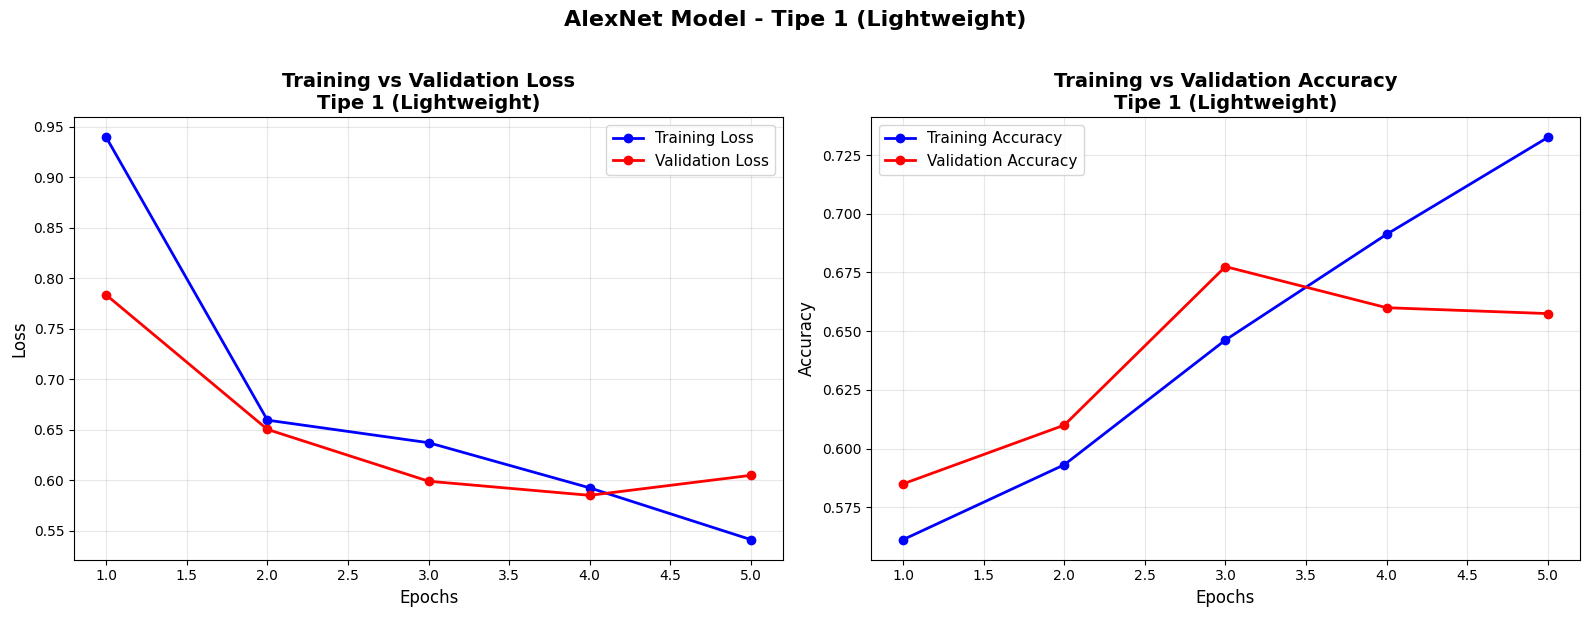


📊 SUMMARY HASIL TRAINING - ALEXNET TIPE 1
Epochs trained: 5/10
Batch Size: 32 | LR: 0.001 | Dropout: 0.3
------------------------------------------------------------
Final Training Loss      : 0.5411
Final Training Accuracy  : 0.7325 (73.25%)
Final Validation Loss    : 0.6048
Final Validation Accuracy: 0.6575 (65.75%)
Training Duration        : 31.73s (0.53 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [14]:
import matplotlib.pyplot as plt

# Ambil data history
loss_values = history_alex.history['loss']
val_loss_values = history_alex.history['val_loss']
accuracy_values = history_alex.history['accuracy']
val_accuracy_values = history_alex.history['val_accuracy']

epochs_range = range(1, len(loss_values) + 1)

# Buat figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values, 'bo-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 1 (Lightweight)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 1 (Lightweight)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('AlexNet Model - Tipe 1 (Lightweight)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - ALEXNET TIPE 1")
print("="*60)
print(f"Epochs trained: {len(loss_values)}/{EPOCHS}")
print(f"Batch Size: {BATCH_SIZE} | LR: {LEARNING_RATE} | Dropout: {DROPOUT_RATE}")
print("-"*60)
print(f"Final Training Loss      : {loss_values[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values[-1]:.4f} ({accuracy_values[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values[-1]:.4f} ({val_accuracy_values[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration:.2f}s ({training_duration/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values[-1] - val_accuracy_values[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

📈 EVALUASI MODEL ALEXNET - TIPE 1

📊 HASIL EVALUASI FINAL - ALEXNET TIPE 1
Final Validation Loss: 0.5990
Final Validation Accuracy: 0.6775 (67.75%)

📊 Classification Report (AlexNet):
------------------------------------------------------------
              precision    recall  f1-score   support

      Female       0.66      0.91      0.77       233
        Male       0.73      0.36      0.48       167

    accuracy                           0.68       400
   macro avg       0.70      0.63      0.62       400
weighted avg       0.69      0.68      0.65       400



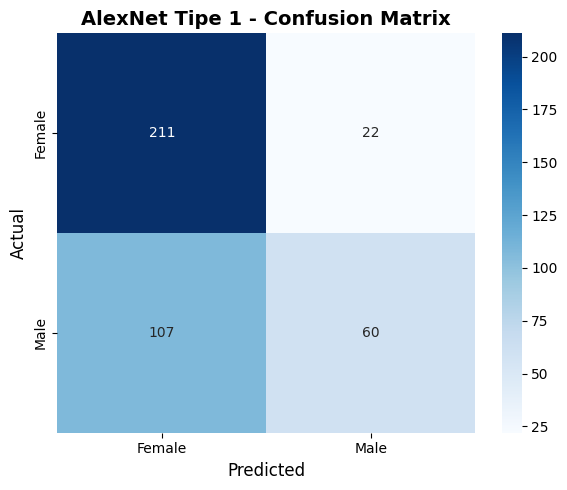


❌ Model AlexNet Tipe 1 perlu perbaikan.


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("="*60)
print("📈 EVALUASI MODEL ALEXNET - TIPE 1")
print("="*60)

# Evaluate
val_loss, val_acc = alexnet.evaluate(val_images, val_labels, verbose=0)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - ALEXNET TIPE 1")
print("="*60)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print("="*60)

# Classification report
val_preds = (alexnet.predict(val_images, verbose=0) > 0.5).astype("int32")

print("\n📊 Classification Report (AlexNet):")
print("-"*60)
print(classification_report(val_labels, val_preds, target_names=['Female', 'Male']))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'])
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("AlexNet Tipe 1 - Confusion Matrix", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Interpretasi
print("\n" + "="*60)
if val_acc > 0.85:
    print("✅ Model AlexNet Tipe 1 memiliki performa BAIK!")
elif val_acc > 0.75:
    print("⚠️  Model AlexNet Tipe 1 cukup baik, masih bisa ditingkatkan.")
else:
    print("❌ Model AlexNet Tipe 1 perlu perbaikan.")
print("="*60)

## AlexNex - V2

### Build AlexNet Model

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def build_alexnet_heavy(input_shape=INPUT_SHAPE, dropout_rate=0.5, learning_rate=0.0001):
    """
    Membangun AlexNet-like model HEAVY untuk binary classification

    Perbedaan dengan Tipe 1:
    - Dropout rate lebih tinggi (0.5 vs 0.3)
    - Learning rate lebih kecil (0.0001 vs 0.001)
    - Akan dilatih dengan epochs lebih banyak & batch size lebih besar

    Args:
        input_shape: Ukuran input (Height, Width, Channels)
        dropout_rate: Dropout rate untuk regularisasi (lebih tinggi)
        learning_rate: Learning rate untuk optimizer (lebih kecil)

    Returns:
        model: AlexNet model yang sudah dikompilasi
    """

    model = models.Sequential([
        # === CONV BLOCK 1 ===
        # Conv1: Large kernel 11x11, stride 4
        layers.Conv2D(96, (11, 11), strides=(4, 4), padding='same',
                      activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # === CONV BLOCK 2 ===
        # Conv2: Kernel 5x5
        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # === CONV BLOCK 3-5 ===
        # Conv3-5: Kernel 3x3
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # === FULLY CONNECTED HEAD ===
        layers.Flatten(),

        # FC1: 512 neurons dengan dropout tinggi
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),  # Dropout 0.5 (lebih tinggi dari Tipe 1)

        # FC2: 512 neurons dengan dropout tinggi
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),

        # === OUTPUT LAYER ===
        layers.Dense(1, activation='sigmoid')
    ])

    # === COMPILE MODEL ===
    # Learning rate lebih kecil untuk training lebih smooth
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("="*60)
print("🟢 BUILD MODEL ALEXNET - TIPE 2 (HEAVY)")
print("="*60)

# Build model dengan hyperparameter Tipe 2
alexnet_heavy = build_alexnet_heavy(
    input_shape=INPUT_SHAPE,
    dropout_rate=0.5,      # Dropout lebih tinggi
    learning_rate=0.0001   # Learning rate lebih kecil
)

print("\n=== Arsitektur Model AlexNet Tipe 2 ===")
alexnet_heavy.summary()

# Hitung total parameter
total_params = alexnet_heavy.count_params()
print(f"\n{'='*60}")
print(f"Total parameters: {total_params:,}")
print(f"{'='*60}")

print("\n📌 Note: Arsitektur SAMA dengan Tipe 1, perbedaan di hyperparameter training")

🟢 BUILD MODEL ALEXNET - TIPE 2 (HEAVY)

=== Arsitektur Model AlexNet Tipe 2 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,109,441 (23.31 MB)

 Trainable params: 6,108,737 (23.30 MB)

 Non-trainable params: 704 (2.75 KB)


Total parameters: 6,109,441

📌 Note: Arsitektur SAMA dengan Tipe 1, perbedaan di hyperparameter training


### Train Model

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
import time

# === KONFIGURASI TRAINING TIPE 2 ===
epochs_heavy = 20      # 2x dari Tipe 1
batch_size_heavy = 64  # 2x dari Tipe 1
learning_rate_heavy = 0.0001  # 10x lebih kecil dari Tipe 1
dropout_rate_heavy = 0.5      # ~1.7x lebih tinggi dari Tipe 1

print("="*60)
print("🟢 TRAINING ALEXNET - TIPE 2 (HEAVY)")
print("="*60)
print(f"Konfigurasi: Heavy - Deep & Comprehensive")
print("-"*60)
print(f"Epochs: {epochs_heavy}")
print(f"Batch Size: {batch_size_heavy}")
print(f"Learning Rate: {learning_rate_heavy}")
print(f"Dropout Rate: {dropout_rate_heavy}")
print("-"*60)
print(f"Total training samples: {len(train_images):,}")
print(f"Total validation samples: {len(val_images):,}")
print(f"Steps per epoch: {len(train_images) // batch_size_heavy}")
print("="*60)

print("\n📌 REASONING TIPE 2 (Heavy):")
print("-"*60)
print("""
- Epochs: 20 (2x dari Tipe 1)
  → Lebih banyak iterasi untuk model belajar pattern kompleks
  → AlexNet butuh waktu lebih untuk konvergen sempurna

- Batch Size: 64 (2x dari Tipe 1)
  → Batch lebih besar = gradient update lebih stabil
  → Mengurangi noise dalam training process
  → Trade-off: Butuh memory lebih besar

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Learning rate kecil untuk fine-tuning lebih halus
  → Mencegah overshoot saat mendekati konvergensi
  → Konvergensi lebih lambat tapi lebih stabil

- Dropout: 0.5 (lebih tinggi dari Tipe 1)
  → Dropout tinggi untuk regularisasi lebih kuat
  → Cegah overfitting di FC layers
  → AlexNet punya banyak params di FC → butuh regularisasi

- AlexNet vs VGG vs GoogleNet vs ResNet (Tipe 2):
  → AlexNet: Large kernels, deep FC, train from scratch
  → VGG: Small kernels stack, train from scratch
  → GoogleNet: Inception, train from scratch
  → ResNet: Fine-tuning pretrained (paling efisien)

✅ COCOK UNTUK: Maximum accuracy dengan AlexNet
""")
print("="*60)

# === EARLY STOPPING CALLBACK ===
# Patience lebih besar untuk training lebih lama
es_heavy = EarlyStopping(
    monitor='val_accuracy',
    patience=3,  # Lebih sabar dari Tipe 1 (2 → 3)
    restore_best_weights=True,
    verbose=1
)

# Catat waktu mulai training
start_time = time.time()

print("\n🚀 Starting AlexNet Heavy training...")
print("-"*60)

# Train model
history_alex_heavy = alexnet_heavy.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=epochs_heavy,
    batch_size=batch_size_heavy,
    callbacks=[es_heavy],
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_heavy = end_time - start_time

print("\n" + "="*60)
print("✅ ALEXNET HEAVY TRAINING FINISHED!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_heavy:.2f} detik ({training_duration_heavy/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_alex_heavy.history['accuracy'][-1]:.4f} ({history_alex_heavy.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_alex_heavy.history['val_accuracy'][-1]:.4f} ({history_alex_heavy.history['val_accuracy'][-1]*100:.2f}%)")
print(f"🛑 Stopped at epoch: {len(history_alex_heavy.history['loss'])}/{epochs_heavy}")
print("="*60)

🟢 TRAINING ALEXNET - TIPE 2 (HEAVY)
Konfigurasi: Heavy - Deep & Comprehensive
------------------------------------------------------------
Epochs: 20
Batch Size: 64
Learning Rate: 0.0001
Dropout Rate: 0.5
------------------------------------------------------------
Total training samples: 1,600
Total validation samples: 400
Steps per epoch: 25

📌 REASONING TIPE 2 (Heavy):
------------------------------------------------------------

- Epochs: 20 (2x dari Tipe 1)
  → Lebih banyak iterasi untuk model belajar pattern kompleks
  → AlexNet butuh waktu lebih untuk konvergen sempurna

- Batch Size: 64 (2x dari Tipe 1)
  → Batch lebih besar = gradient update lebih stabil
  → Mengurangi noise dalam training process
  → Trade-off: Butuh memory lebih besar

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Learning rate kecil untuk fine-tuning lebih halus
  → Mencegah overshoot saat mendekati konvergensi
  → Konvergensi lebih lambat tapi lebih stabil

- Dropout: 0.5 (lebih tinggi dari Tip

### Plot Training History

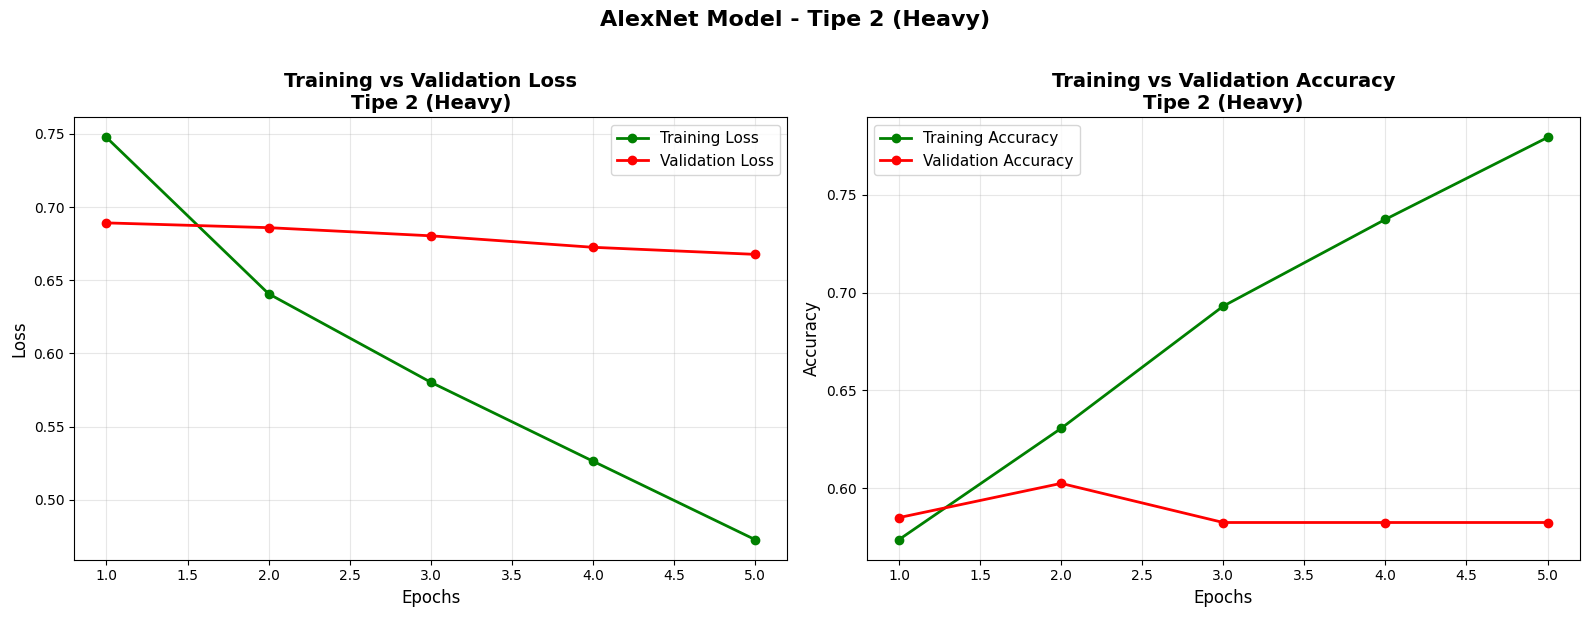


📊 SUMMARY HASIL TRAINING - ALEXNET TIPE 2
Epochs trained: 5/20
Batch Size: 64 | LR: 0.0001 | Dropout: 0.5
------------------------------------------------------------
Final Training Loss      : 0.4728
Final Training Accuracy  : 0.7794 (77.94%)
Final Validation Loss    : 0.6677
Final Validation Accuracy: 0.5825 (58.25%)
Training Duration        : 26.77s (0.45 min)
------------------------------------------------------------
⚠️  OVERFITTING TERDETEKSI!
   Gap: 0.1969 (19.69%)


In [18]:
import matplotlib.pyplot as plt

# Ambil data history
loss_values_heavy = history_alex_heavy.history['loss']
val_loss_values_heavy = history_alex_heavy.history['val_loss']
accuracy_values_heavy = history_alex_heavy.history['accuracy']
val_accuracy_values_heavy = history_alex_heavy.history['val_accuracy']

epochs_range = range(1, len(loss_values_heavy) + 1)

# Buat figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_heavy, 'go-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_heavy, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 2 (Heavy)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_heavy, 'go-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_heavy, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 2 (Heavy)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('AlexNet Model - Tipe 2 (Heavy)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - ALEXNET TIPE 2")
print("="*60)
print(f"Epochs trained: {len(loss_values_heavy)}/{epochs_heavy}")
print(f"Batch Size: {batch_size_heavy} | LR: {learning_rate_heavy} | Dropout: {dropout_rate_heavy}")
print("-"*60)
print(f"Final Training Loss      : {loss_values_heavy[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_heavy[-1]:.4f} ({accuracy_values_heavy[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_heavy[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_heavy[-1]:.4f} ({val_accuracy_values_heavy[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_heavy:.2f}s ({training_duration_heavy/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_heavy[-1] - val_accuracy_values_heavy[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

📈 EVALUASI MODEL ALEXNET - TIPE 2

📊 HASIL EVALUASI FINAL - ALEXNET TIPE 2
Final Validation Loss: 0.6859
Final Validation Accuracy: 0.6025 (60.25%)

📊 Classification Report (AlexNet Heavy):
------------------------------------------------------------
              precision    recall  f1-score   support

      Female       0.60      0.99      0.74       233
        Male       0.83      0.06      0.11       167

    accuracy                           0.60       400
   macro avg       0.71      0.53      0.43       400
weighted avg       0.69      0.60      0.48       400



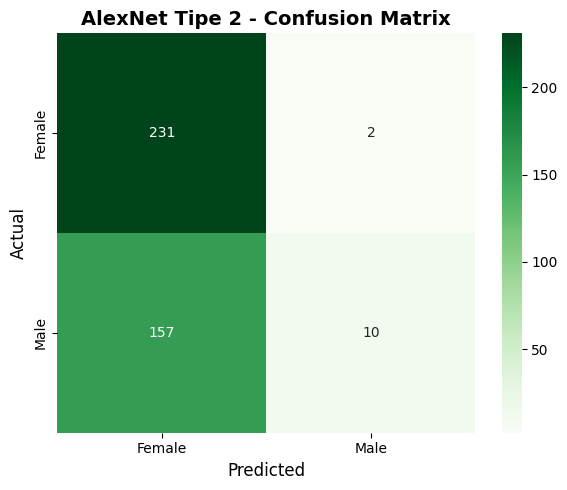


❌ Model AlexNet Tipe 2 perlu perbaikan.


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("="*60)
print("📈 EVALUASI MODEL ALEXNET - TIPE 2")
print("="*60)

# Evaluate
val_loss_heavy, val_acc_heavy = alexnet_heavy.evaluate(val_images, val_labels, verbose=0)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - ALEXNET TIPE 2")
print("="*60)
print(f"Final Validation Loss: {val_loss_heavy:.4f}")
print(f"Final Validation Accuracy: {val_acc_heavy:.4f} ({val_acc_heavy*100:.2f}%)")
print("="*60)

# Classification report
val_preds_heavy = (alexnet_heavy.predict(val_images, verbose=0) > 0.5).astype("int32")

print("\n📊 Classification Report (AlexNet Heavy):")
print("-"*60)
print(classification_report(val_labels, val_preds_heavy, target_names=['Female', 'Male']))

# Confusion matrix
cm_heavy = confusion_matrix(val_labels, val_preds_heavy)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_heavy, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'])
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("AlexNet Tipe 2 - Confusion Matrix", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Interpretasi
print("\n" + "="*60)
if val_acc_heavy > 0.85:
    print("✅ Model AlexNet Tipe 2 memiliki performa BAIK!")
elif val_acc_heavy > 0.75:
    print("⚠️  Model AlexNet Tipe 2 cukup baik, masih bisa ditingkatkan.")
else:
    print("❌ Model AlexNet Tipe 2 perlu perbaikan.")
print("="*60)

## Test (V1 + V2)

🔵🟢 TEST PREDIKSI - ALEXNET TIPE 1 & TIPE 2
Upload gambar sekali, test di kedua model sekaligus
------------------------------------------------------------


Saving LUCINTA.webp to LUCINTA.webp

📷 Memproses gambar: "LUCINTA.webp"
Ukuran file: 6,030 bytes

📊 HASIL PREDIKSI UNTUK: LUCINTA.webp
🔵 ALEXNET TIPE 1 (Lightweight):
   Prediksi: Male
   Prob Male: 0.5647 (56.47%)
   Confidence: 0.5647 (56.47%)

🟢 ALEXNET TIPE 2 (Heavy):
   Prediksi: Female
   Prob Male: 0.4970 (49.70%)
   Confidence: 0.5030 (50.30%)

⚠️  PREDIKSI BERBEDA!
   Tipe 1: Male (56.47%)
   Tipe 2: Female (50.30%)


/tmp/ipython-input-2879840810.py:135: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2879840810.py:135: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


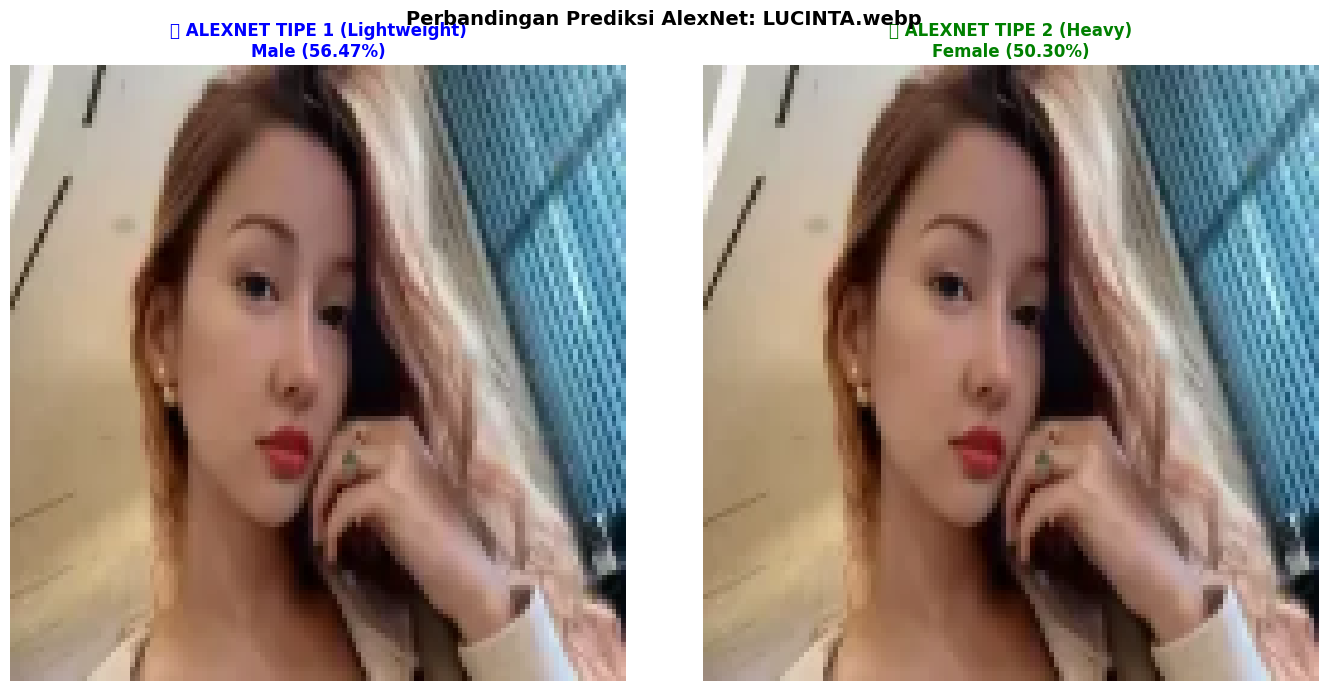


✅ Prediksi kedua model selesai!


In [20]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("🔵🟢 TEST PREDIKSI - ALEXNET TIPE 1 & TIPE 2")
print("="*60)
print("Upload gambar sekali, test di kedua model sekaligus")
print("-"*60)

# Upload gambar dari komputer lokal
uploaded = files.upload()

# Simpan hasil prediksi untuk perbandingan
predictions_comparison = []

# Proses setiap gambar yang diupload
for fn in uploaded.keys():
    print(f'\n{"="*60}')
    print(f'📷 Memproses gambar: "{fn}"')
    print(f'Ukuran file: {len(uploaded[fn]):,} bytes')
    print(f'{"="*60}')

    # Baca gambar
    image_path = fn
    img = cv2.imread(image_path)

    if img is None:
        print(f"❌ Error: Tidak dapat membaca gambar {image_path}")
        continue

    # === PREPROCESSING (SAMA DENGAN TRAINING) ===

    # 1. Resize ke ukuran input model (128x128 untuk AlexNet)
    target_size = (128, 128)
    img_resized = cv2.resize(img, target_size)

    # 2. Konversi BGR (OpenCV) ke RGB (sesuai training)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # 3. Normalisasi: ubah range piksel dari [0, 255] ke [0, 1]
    img_normalized = img_rgb.astype('float32') / 255.0

    # 4. Tambah dimensi batch: (128, 128, 3) -> (1, 128, 128, 3)
    img_input = np.expand_dims(img_normalized, axis=0)

    # === PREDIKSI DENGAN KEDUA MODEL ===
    results = {}

    # Prediksi Model Tipe 1
    if 'alexnet' in globals():
        pred1 = alexnet.predict(img_input, verbose=0)
        prob_male_1 = pred1[0][0]
        class_1 = "Male" if prob_male_1 > 0.5 else "Female"
        conf_1 = prob_male_1 if prob_male_1 > 0.5 else (1 - prob_male_1)
        results['type1'] = {
            'prob_male': prob_male_1,
            'class': class_1,
            'confidence': conf_1
        }
    else:
        print("⚠️  Model Tipe 1 tidak ditemukan, skip prediksi Tipe 1")

    # Prediksi Model Tipe 2
    if 'alexnet_heavy' in globals():
        pred2 = alexnet_heavy.predict(img_input, verbose=0)
        prob_male_2 = pred2[0][0]
        class_2 = "Male" if prob_male_2 > 0.5 else "Female"
        conf_2 = prob_male_2 if prob_male_2 > 0.5 else (1 - prob_male_2)
        results['type2'] = {
            'prob_male': prob_male_2,
            'class': class_2,
            'confidence': conf_2
        }
    else:
        print("⚠️  Model Tipe 2 tidak ditemukan, skip prediksi Tipe 2")

    # Simpan hasil untuk tabel perbandingan
    if 'type1' in results and 'type2' in results:
        predictions_comparison.append({
            'filename': fn,
            'type1_prob_male': results['type1']['prob_male'],
            'type1_class': results['type1']['class'],
            'type1_conf': results['type1']['confidence'],
            'type2_prob_male': results['type2']['prob_male'],
            'type2_class': results['type2']['class'],
            'type2_conf': results['type2']['confidence']
        })

    # === TAMPILKAN HASIL SIDE-BY-SIDE ===
    print(f"\n📊 HASIL PREDIKSI UNTUK: {fn}")
    print(f"="*60)

    if 'type1' in results:
        print(f"🔵 ALEXNET TIPE 1 (Lightweight):")
        print(f"   Prediksi: {results['type1']['class']}")
        print(f"   Prob Male: {results['type1']['prob_male']:.4f} ({results['type1']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type1']['confidence']:.4f} ({results['type1']['confidence']*100:.2f}%)")

    if 'type2' in results:
        print(f"\n🟢 ALEXNET TIPE 2 (Heavy):")
        print(f"   Prediksi: {results['type2']['class']}")
        print(f"   Prob Male: {results['type2']['prob_male']:.4f} ({results['type2']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type2']['confidence']:.4f} ({results['type2']['confidence']*100:.2f}%)")

    # Cek apakah prediksi sama atau beda
    if 'type1' in results and 'type2' in results:
        if results['type1']['class'] == results['type2']['class']:
            print(f"\n✅ KEDUA MODEL SEPAKAT: {results['type1']['class']}")
        else:
            print(f"\n⚠️  PREDIKSI BERBEDA!")
            print(f"   Tipe 1: {results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)")
            print(f"   Tipe 2: {results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)")

    print(f"="*60)

    # === VISUALISASI SIDE-BY-SIDE ===
    if 'type1' in results and 'type2' in results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Model Tipe 1
        axes[0].imshow(img_rgb)
        axes[0].set_title(f"🔵 ALEXNET TIPE 1 (Lightweight)\n{results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='blue')
        axes[0].axis('off')

        # Model Tipe 2
        axes[1].imshow(img_rgb)
        axes[1].set_title(f"🟢 ALEXNET TIPE 2 (Heavy)\n{results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='green')
        axes[1].axis('off')

        plt.suptitle(f"Perbandingan Prediksi AlexNet: {fn}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

print("\n" + "="*60)
print("✅ Prediksi kedua model selesai!")
print("="*60)